In [1]:
from itertools import combinations
import numpy as np
import sys
from oxDNA_analysis_tools.UTILS.oxview import oxdna_conf, from_path
from oxDNA_analysis_tools.UTILS.RyeReader import describe, get_confs, inbox
from oxDNA_analysis_tools.UTILS.data_structures import TopInfo, TrajInfo
from pathlib import Path
import os
from ipy_oxdna.dna_structure import DNAStructure, DNAStructureStrand, load_dna_structure, DNABase, strand_from_info
from copy import deepcopy
from ipy_oxdna.oxdna_simulation import Simulation, SimulationManager
import copy
from tqdm.auto import tqdm

from ipy_oxdna.oxdna_simulation import Simulation, SimulationManager
import os
import random

In [2]:
base_path = '/home/ava/MetaBackbone_project/Metabackbone-scripts/structure_files/six_helix_oxdna_file/unmodified/1512_bp'

def load_dna_structure_files(base_path):
    
    dat_path = os.path.join(base_path, '1512_bp.dat')
    top_path = os.path.join(base_path, '1512_bp.top')
    dna = load_dna_structure(top_path, dat_path)
    return dna

In [3]:
dna = load_dna_structure_files(base_path)

In [4]:
def find_longest_strand(dna):
    longest_strand = None
    longest_strand_index = -1
    max_length = 0
    
    for index, strand in enumerate(dna.strands):
        if len(strand.bases) > max_length:
            max_length = len(strand.bases)
            longest_strand = strand
            longest_strand_index = index
    
    return longest_strand, longest_strand_index

In [5]:
longest_strand, longest_strand_index = list(find_longest_strand(dna))      # Has been checked with the oxview information and they match
print (longest_strand)
print(longest_strand_index)
print(len(longest_strand))

2
1512


In [6]:
def find_cross_over_in_longest_strand(longest_strand):
    
    min_distance = float('inf')
    max_index_difference = 0
    cross_over_bases_max = (None, None)
    num_bases = len(longest_strand)

    for i in range(num_bases):
        
        for j in range(i + 1, num_bases):
            
            base_i = longest_strand[i]
            base_j = longest_strand[j]
            index_difference = abs(base_i.uid - base_j.uid)
            distance = np.linalg.norm(np.array(base_i.pos) - np.array(base_j.pos))

            if index_difference > max_index_difference or (index_difference == max_index_difference and distance < min_distance):
                max_index_difference = index_difference
                min_distance = distance
                cross_over_bases_max = (base_i, base_j)

    return cross_over_bases_max, max_index_difference, min_distance

In [7]:
cross_over_bases_max, max_index_difference, min_distance = find_cross_over_in_longest_strand(longest_strand)          # Has been checked with the oxview info and they match
print("cross_over_bases_max:",cross_over_bases_max)
print("max_index_difference:", max_index_difference)
print("min_distance:", min_distance)

cross_over_bases_max: (DNABase(uid=43, base='T', pos=array([ 2.10507846, -0.6867429 ,  0.12683482]), a1=array([ 0.17443815, -0.98466813,  0.        ]), a3=array([0., 0., 1.])), DNABase(uid=1554, base='T', pos=array([2.37799716, 0.69653118, 0.12683482]), a1=array([-0.28042587,  0.95987568,  0.        ]), a3=array([ 0.,  0., -1.])))
max_index_difference: 1511
min_distance: 1.4099403509855792


In [8]:
def find_nearest_pairs(longest_strand, cross_over_bases_max, min_distance):
    
    num_bases = len(longest_strand)
    similar_distance_pairs = []
    distance_tolerance = 0.1 * min_distance
    vicinity_tolerance = 1.0  

    for i in range(num_bases):
        for j in range(i + 1, num_bases):
            base_i = longest_strand[i]
            base_j = longest_strand[j]
            distance = np.linalg.norm(np.array(base_i.pos) - np.array(base_j.pos))
            
            # Check if the distance is within the tolerance range of the min_distance
            if abs(distance - min_distance) <= distance_tolerance:
                
                # Check if the bases are in the vicinity of the cross_over_bases_max pair
                dist_to_max_0 = np.linalg.norm(np.array(base_i.pos) - np.array(cross_over_bases_max[0].pos))
                dist_to_max_1 = np.linalg.norm(np.array(base_j.pos) - np.array(cross_over_bases_max[1].pos))

                if dist_to_max_0 <= vicinity_tolerance and dist_to_max_1 <= vicinity_tolerance:
                    
                    # Avoid selecting the same pair as cross_over_bases_max
                    if {base_i.uid, base_j.uid} != {cross_over_bases_max[0].uid, cross_over_bases_max[1].uid}:
                        similar_distance_pairs.append((base_i, base_j, distance))
    
    # Select two pairs closest to the min_distance
    similar_distance_pairs_sorted = sorted(similar_distance_pairs, key=lambda x: abs(x[2] - min_distance))
    closest_pairs = similar_distance_pairs_sorted[:2]  # Get up to two closest pairs

    return closest_pairs

In [9]:
closest_pairs = find_nearest_pairs(longest_strand, cross_over_bases_max, min_distance)
print("closest_pairs:", closest_pairs)
print("closest_pairs_length:", len(closest_pairs))

closest_pairs: [(DNABase(uid=43, base='T', pos=array([ 2.10507846, -0.6867429 ,  0.12683482]), a1=array([ 0.17443815, -0.98466813,  0.        ]), a3=array([0., 0., 1.])), DNABase(uid=1051, base='G', pos=array([ 2.0472362 ,  0.69488323, -0.26292804]), a1=array([0.27084196, 0.96262383, 0.        ]), a3=array([ 0.,  0., -1.])), 1.4367155518576382), (DNABase(uid=1050, base='C', pos=array([ 2.45607257, -0.73044026, -0.26292804]), a1=array([-0.41054827, -0.91183887,  0.        ]), a3=array([0., 0., 1.])), DNABase(uid=1554, base='T', pos=array([2.37799716, 0.69653118, 0.12683482]), a1=array([-0.28042587,  0.95987568,  0.        ]), a3=array([ 0.,  0., -1.])), 1.4813029187590172)]
closest_pairs_length: 2


In [10]:
closest_pairs_positions = [(pair[0].pos, pair[1].pos) for pair in closest_pairs]

print(f"Cross Over Bases Max: {cross_over_bases_max}")
print(f"Max Index Difference: {max_index_difference}")
print(f"Min Distance: {min_distance}")
print(f"Closest Pairs: {closest_pairs}")
print(f"Closest Pairs Positions: {closest_pairs_positions}")

Cross Over Bases Max: (DNABase(uid=43, base='T', pos=array([ 2.10507846, -0.6867429 ,  0.12683482]), a1=array([ 0.17443815, -0.98466813,  0.        ]), a3=array([0., 0., 1.])), DNABase(uid=1554, base='T', pos=array([2.37799716, 0.69653118, 0.12683482]), a1=array([-0.28042587,  0.95987568,  0.        ]), a3=array([ 0.,  0., -1.])))
Max Index Difference: 1511
Min Distance: 1.4099403509855792
Closest Pairs: [(DNABase(uid=43, base='T', pos=array([ 2.10507846, -0.6867429 ,  0.12683482]), a1=array([ 0.17443815, -0.98466813,  0.        ]), a3=array([0., 0., 1.])), DNABase(uid=1051, base='G', pos=array([ 2.0472362 ,  0.69488323, -0.26292804]), a1=array([0.27084196, 0.96262383, 0.        ]), a3=array([ 0.,  0., -1.])), 1.4367155518576382), (DNABase(uid=1050, base='C', pos=array([ 2.45607257, -0.73044026, -0.26292804]), a1=array([-0.41054827, -0.91183887,  0.        ]), a3=array([0., 0., 1.])), DNABase(uid=1554, base='T', pos=array([2.37799716, 0.69653118, 0.12683482]), a1=array([-0.28042587,  0

In [11]:
def measure_pair_distances(closest_pairs):
    if len(closest_pairs) < 2:
        print("\nNot enough pairs in the closest_pairs list to perform the operation.\n")
        return

    first_pair = closest_pairs[0]
    second_pair = closest_pairs[1]

    base1_first_pair = first_pair[0]
    base2_first_pair = first_pair[1]
    base1_second_pair = second_pair[0]
    base2_second_pair = second_pair[1]

    distances = []

    def calculate_distance(base_a, base_b, description):
        distance = np.linalg.norm(np.array(base_a.pos) - np.array(base_b.pos))
        distances.append((description, base_a, base_b, distance))
        return distance

    distance_between_bases_1_2 = calculate_distance(base1_first_pair, base2_second_pair, "Pairing base1 of the first pair with base2 of the second pair")
    distance_between_bases_2_1 = calculate_distance(base2_first_pair, base1_second_pair, "Pairing base2 of the first pair with base1 of the second pair")
    distance_between_bases_2_2 = calculate_distance(base2_first_pair, base2_second_pair, "Pairing base2 of the first pair with base2 of the second pair")
    distance_between_base1s = calculate_distance(base1_first_pair, base1_second_pair, "Pairing base1 of the first pair with base1 of the second pair")

    for description, base_a, base_b, distance in distances:
        print(f"\n{description}:\n")
        print(f"Base A: UID = {base_a.uid}, Position = {base_a.pos}")
        print(f"Base B: UID = {base_b.uid}, Position = {base_b.pos}")
        print(f"Distance between them: {distance}\n")

In [12]:
measure_pair_distances(closest_pairs)


Pairing base1 of the first pair with base2 of the second pair:

Base A: UID = 43, Position = [ 2.10507846 -0.6867429   0.12683482]
Base B: UID = 1554, Position = [2.37799716 0.69653118 0.12683482]
Distance between them: 1.4099403509855792


Pairing base2 of the first pair with base1 of the second pair:

Base A: UID = 1051, Position = [ 2.0472362   0.69488323 -0.26292804]
Base B: UID = 1050, Position = [ 2.45607257 -0.73044026 -0.26292804]
Distance between them: 1.4827994516512886


Pairing base2 of the first pair with base2 of the second pair:

Base A: UID = 1051, Position = [ 2.0472362   0.69488323 -0.26292804]
Base B: UID = 1554, Position = [2.37799716 0.69653118 0.12683482]
Distance between them: 0.5111952810836146


Pairing base1 of the first pair with base1 of the second pair:

Base A: UID = 43, Position = [ 2.10507846 -0.6867429   0.12683482]
Base B: UID = 1050, Position = [ 2.45607257 -0.73044026 -0.26292804]
Distance between them: 0.5263282380143033



In [13]:
left_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439,1440,1441,1442,1443,1444,1445,1446,1447,1448,1449,1450,1451,1452,1453,1454,2293,2294,2295,2301,2302,2303,2304,2305,2306,2307,2308,2309,2310,2311,2312,2313,2314,2315,2316,2317,2318,2319,2320,2321,2322,2323,2324,2325,2326,2327,2328,2329,2330,2331,2332,2333,2334,2335,2336,2337,2338,2339,2340,2341,2342,2343,2344,2345,2346,2347,2348,2349,2350,2351,2352,2353,2354,2355,2356,2357,2358,2359,2360,2361,2362,2363,2364,2365,2366,2367,2368,2369,2370,2371,2372,2373,2374,2375,2376,2377,2378,2379,2380,2381,2783,2784,2785,2786,2787,2788,2789,2802,2803,2804,2805,2806,3011,3012,3013,3014,3015,3016,3017,3018,3019,3020,3021,3022,3023,3024,3025,3026,3027,3028,3029,3030,3031,3032,3033,3034,3035,3036,3037,3038,3039,3040,3041,3042,3043,3044,3045,3046,3047,3048,3049,3050,3051,3052,3053,3054,3055,3056,3057,3058,3059,3060,3061,3062,3063,3064,3065,3066,3067]
right_indices = [20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,1139,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151,1152,1153,1154,1155,1156,1157,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1171,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199,1555,1556,1557,1558,1559,1560,1561,1562,1563,1564,1565,1566,1567,1568,1569,1570,1571,1572,1573,1574,1575,1576,1577,1578,1579,1580,1581,1582,1583,1584,1585,1586,1587,1588,1589,1590,1591,1592,1593,1594,1595,1596,1597,1598,1599,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,1610,1611,1612,1613,1614,1615,1616,1617,1618,1619,1620,1621,1622,1623,1624,1625,1626,1627,1628,1629,1630,1631,1632,1633,1634,1635,1636,1637,1638,1639,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652,1653,1654,1655,1656,1657,1658,1667,1668,1669,1670,2382,2383,2384,2385,2386,2387,2388,2389,2390,2391,2392,2393,2394,2395,2396,2397,2398,2399,2400,2401,2402,2403,2404,2405,2406,2407,2408,2409,2410,2411,2412,2413,2414,2415,2416,2417,2418,2419,2420,2421,2422,2423,2424,2425,2426,2427,2428,2429,2430,2431,2432,2433,2434,2435,2436,2437,2438,2439,2440,2441,2442,2443,2444,2445,2446,2447,2448,2449,2450,2451,2452,2453,2454,2455,2456,2457,2458,2459,2460,2461,2462,2463,2464,2465,2466,2467,2479,2480,2481,2482,2483,2484,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500,2501,2502,2818,2819,2820,2821,2822,2823]

def calculate_position(dna, left_indices, right_indices):
    left_pos = []
    right_pos = []

    # Collect positions for left indices
    for strand in dna.strands:
        for base in strand:
            if base.uid in left_indices:
                left_pos.append(base.pos)

    # Collect positions for right indices
    for strand in dna.strands:
        for base in strand:
            if base.uid in right_indices:
                right_pos.append(base.pos)

    # Debugging statements
    all_uids = [base.uid for strand in dna.strands for base in strand]
    print(f"All base UIDs in DNA: {all_uids}")
    print(f"Left indices: {left_indices}")
    print(f"Right indices: {right_indices}")
    print(f"Left positions found: {left_pos}")
    print(f"Right positions found: {right_pos}")

    if left_pos:
        cms_left_side = np.mean(left_pos, axis=0)
    else:
        raise ValueError("No positions found for left indices.")

    if right_pos:
        cms_right_side = np.mean(right_pos, axis=0)
    else:
        raise ValueError("No positions found for right indices.")

    return cms_left_side, cms_right_side

In [15]:
def is_point_far_from_crossovers(point, crossover_positions, min_distance_threshold):
    for pos in crossover_positions:
        distance = np.linalg.norm(np.array(point) - np.array(pos))
        if distance < min_distance_threshold:
            return False
    return True

In [14]:
def find_valid_point(dna, left_indices, right_indices, longest_strand, min_distance_threshold=5.0):
    
    cms_left_side, cms_right_side = calculate_position(dna, left_indices, right_indices)

    
    cross_over_bases, max_index_difference, min_distance = find_cross_over_in_longest_strand(longest_strand)
    crossover_positions = [base.pos for base in cross_over_bases if base is not None]

   
    t = random.uniform(0, 1)
    first_P = np.array(cms_left_side + t * (cms_right_side - cms_left_side))

    if not crossover_positions:
        return first_P

    # Find a valid point far from the crossovers
    while True:
        t = random.uniform(0, 1)
        P = np.array(cms_left_side + t * (cms_right_side - cms_left_side))

        if is_point_far_from_crossovers(P, crossover_positions, min_distance_threshold):
            return P

In [16]:
point = find_valid_point(dna, left_indices, right_indices, longest_strand)
print(f"Valid point P: {point}")

# Additionally, you can print the crossover data if needed
cross_over_bases, max_index_difference, min_distance = find_cross_over_in_longest_strand(longest_strand)
print(f"Cross over bases: {cross_over_bases}")
print(f"Max index difference: {max_index_difference}")
print(f"Min distance: {min_distance}")

All base UIDs in DNA: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 21

In [17]:
def find_nearby_points(dna, point, min_distance, max_distance, num_points=5):
    left_nearby_points = []
    right_nearby_points = []

    # Determine the main axis direction (from left to right indices)
    left_indices_positions = [np.array(base.pos) for strand in dna.strands for base in strand if base.uid in left_indices]
    right_indices_positions = [np.array(base.pos) for strand in dna.strands for base in strand if base.uid in right_indices]
    
    cms_left_side = np.mean(left_indices_positions, axis=0)
    cms_right_side = np.mean(right_indices_positions, axis=0)
    
    direction_vector = cms_right_side - cms_left_side
    direction_vector = direction_vector / np.linalg.norm(direction_vector)  # Normalize the direction vector

    for strand in dna.strands:
        for base in strand:
            pos = np.array(base.pos)
            dist = np.linalg.norm(pos - point)

            if min_distance < dist < max_distance:
                vector_from_P = pos - point
                projection = np.dot(vector_from_P, direction_vector)

                if projection < 0:  # Point is to the left of P along the reference axis
                    left_nearby_points.append(pos)
                else:  # Point is to the right of P along the reference axis
                    right_nearby_points.append(pos)

    if len(left_nearby_points) > num_points:
        indices = np.random.choice(range(len(left_nearby_points)), num_points, replace=False)
        left_nearby_points = [left_nearby_points[i] for i in indices]

    if len(right_nearby_points) > num_points:
        indices = np.random.choice(range(len(right_nearby_points)), num_points, replace=False)
        right_nearby_points = [right_nearby_points[i] for i in indices]

    print(f"Point P: {point}")
    print(f"Left nearby points: {left_nearby_points}")
    print(f"Right nearby points: {right_nearby_points}")

    return left_nearby_points, right_nearby_points

In [18]:
def calculate_angle_between_vectors(dna, left_indices, right_indices, point):
    left_points = []
    right_points = []

    for strand in dna.strands:
        for base in strand:
            if base.uid in left_indices:
                left_points.append(base.pos)
            elif base.uid in right_indices:
                right_points.append(base.pos)

    # Calculate the center of mass for left and right points
    left_com = np.mean(left_points, axis=0)
    right_com = np.mean(right_points, axis=0)
    
    print(f"Left center of mass: {left_com}")
    print(f"Right center of mass: {right_com}")

    # Create vectors from P to the centers of mass
    vector_left = left_com - point
    vector_right = right_com - point

    # Calculate the angle between the vectors
    cos_theta = np.dot(vector_left, vector_right) / (np.linalg.norm(vector_left) * np.linalg.norm(vector_right))
    angle = np.arccos(cos_theta)

    return np.degrees(angle)

In [20]:
point = find_valid_point(dna, left_indices, right_indices, longest_strand)
print(f"Valid point P: {point}")

# Calculate the angle between vectors using the found point
angle = calculate_angle_between_vectors(dna, left_indices, right_indices, point)
print(f"Angle between vectors: {angle} degrees")

All base UIDs in DNA: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 21

In [21]:
sphere_radius = 3.5

def find_bases_in_sphere(dna, point, sphere_radius):
    bases_in_sphere = []
    base_to_strand_mapping = {}
    
    for strand_index, strand in enumerate(dna.strands):
        for base in strand:
            base_position = np.array(base.pos)
            distance = np.linalg.norm(base_position - point)
            # print(f"Base UID: {base.uid}, Position: {base_position}, Distance to P: {distance}")

            if distance < sphere_radius:
                bases_in_sphere.append(base.uid)
                base_to_strand_mapping[base.uid] = strand_index
                # print(f"Base UID {base.uid} is within the sphere radius")
    
    return bases_in_sphere, base_to_strand_mapping

In [22]:
bases_in_sphere, base_to_strand_mapping = find_bases_in_sphere(dna, point, sphere_radius)
print('bases_in_sphere:', bases_in_sphere)
print('base_to_strand_mapping:', base_to_strand_mapping)
print('Number_bases_in_sphere:', len(bases_in_sphere))

bases_in_sphere: [598, 599, 600, 601, 602, 603, 604, 605, 606, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 985, 986, 987, 988, 989, 990, 991, 992, 993, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1731, 1732, 1733, 1734, 1741, 1742, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1788, 1789, 1790, 1791, 1792, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2522, 2523, 2524, 2525, 2526, 2569, 2570, 2571, 2572, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859]
base_to_strand_mapping: {598: 2, 599: 2, 600: 2, 601: 2, 602: 2, 603: 2, 604: 2, 605: 2, 606: 2, 726: 2, 727: 2, 728: 2, 729: 2, 730: 2, 731: 2, 732: 2, 733: 2, 734: 2, 735: 2, 736: 2, 737: 2, 738: 2

In [23]:
def remove_one_strand_in_sphere(dna, point, sphere_radius):
    
    bases_in_sphere, base_to_strand_mapping = find_bases_in_sphere(dna, point, sphere_radius)
    longest_strand, longest_strand_index = find_longest_strand(dna)
    
    print(f"Bases in sphere: {bases_in_sphere}")
    print(f"Base to strand mapping: {base_to_strand_mapping}")
    print(f"Longest strand: {longest_strand}")
    print(f"Longest strand index: {longest_strand_index}")
    
    strands_to_remove = set(base_to_strand_mapping.values()) - {longest_strand_index}
    print(f"Strands to remove: {strands_to_remove}")
    
    dna_structures = []
    
    for strand_index in strands_to_remove:
        strand_list = []
        
        for idx, strand in enumerate(dna.strands):
            if idx != strand_index:
                strand_list.append(strand)
        
        # Print the index of the strand that is being removed
        print(f"Removing strand with index: {strand_index}")
        
        new_dna_structure = DNAStructure(strand_list, dna.time, dna.box, dna.energy)
        dna_structures.append(new_dna_structure)
        
        # Uncomment and modify these lines if you want to export the structure files
        # export_path = '/home/ava/Dropbox (ASU)/temp/Metabackbone/structure_files/six_helix_oxdna_file/Automatically_removed_staples/1512_bp'
        # Generate paths for exporting the new structure
        # dat_path = os.path.join(export_path, '1512_bp_rmv_stpls.dat')
        # top_path = os.path.join(export_path, '1512_bp_rmv_stpls.top')
        # Export the topology and configuration files
        # new_dna_structure.export_top_conf(Path(top_path), Path(dat_path))
    
    return dna_structures

In [24]:
new_dna_structures = remove_one_strand_in_sphere(dna, point, sphere_radius)
print(new_dna_structures)
print(len(new_dna_structures))

Bases in sphere: [598, 599, 600, 601, 602, 603, 604, 605, 606, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 985, 986, 987, 988, 989, 990, 991, 992, 993, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1731, 1732, 1733, 1734, 1741, 1742, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1788, 1789, 1790, 1791, 1792, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2522, 2523, 2524, 2525, 2526, 2569, 2570, 2571, 2572, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859]
Base to strand mapping: {598: 2, 599: 2, 600: 2, 601: 2, 602: 2, 603: 2, 604: 2, 605: 2, 606: 2, 726: 2, 727: 2, 728: 2, 729: 2, 730: 2, 731: 2, 732: 2, 733: 2, 734: 2, 735: 2, 736: 2, 737: 2, 738: 2

In [25]:

def export_dna_structures(new_dna_structures, base_path):
    """
    Exports new DNA structures to unique subdirectories and collects their output paths.
    
    Parameters:
    new_dna_structures : List[DNAStructure]
        List of new DNA structure objects to be saved.
    base_path : str
        The base directory path where the structures will be saved.
    
    Returns:
    List[dict]
        List of dictionaries containing structure ID and file paths.
    """
    output_paths = []
    
    for i, new_dna in enumerate(new_dna_structures):
        
        structure_id = i  
        unique_subdir = os.path.join(base_path, f'structure_{structure_id}')
        os.makedirs(unique_subdir, exist_ok=True)
        dat_path = os.path.join(unique_subdir, '1512_bp_rmv_staples.dat')
        top_path = os.path.join(unique_subdir, '1512_bp_rmv_staples.top')
        
        new_dna.export_top_conf(Path(top_path), Path(dat_path))
        
        output_paths.append({
            'structure_id': structure_id,
            'dat_path': dat_path,
            'top_path': top_path
        })

    return output_paths

In [26]:
base_path = '/home/ava/MetaBackbone_project/Metabackbone-scripts/structure_files/six_helix_oxdna_file/Automatically_removed_staples/1512_bp/one_staple_remvd'
output_paths_one = export_dna_structures(new_dna_structures, base_path)

In [28]:
def remove_two_strands_in_sphere(dna, point, sphere_radius):
    bases_in_sphere, base_to_strand_mapping = find_bases_in_sphere(dna, point, sphere_radius)
    longest_strand, longest_strand_index = find_longest_strand(dna)
    
    print("Bases in sphere:", bases_in_sphere)
    print("Base to strand mapping:", base_to_strand_mapping)
    print("Longest strand:", longest_strand)
    print("Longest strand index:", longest_strand_index)
    
    strands_to_remove = set(base_to_strand_mapping.values()) - {longest_strand_index}
    print("Strands to remove:", strands_to_remove)

    dna_structures = []
    removed_strands_info = []

    # Create all possible pairs of strands to remove
    strand_pairs = [(strand_1, strand_2) for i, strand_1 in enumerate(strands_to_remove)
                    for strand_2 in list(strands_to_remove)[i + 1:]]

    for strand_1, strand_2 in strand_pairs:
        strand_list = []
        for idx, strand in enumerate(dna.strands):
            if idx not in {strand_1, strand_2}:
                strand_list.append(strand)
        
        new_dna_structure = DNAStructure(strand_list, dna.time, dna.box, dna.energy)
        dna_structures.append(new_dna_structure)
        
        # Store the information about removed strands
        removed_strands_info.append((strand_1, strand_2))
        print(f"Removed strands: {strand_1}, {strand_2}")
        
        # Uncomment the following lines if you need to export the structure files
        # export_path = '/home/ava/Dropbox (ASU)/temp/Metabackbone/structure_files/six_helix_oxdna_file/Automatically_removed_staples/1512_bp'
        # dat_path = os.path.join(export_path, f'1512_bp_rmv_stpls_{strand_1}_{strand_2}.dat')
        # top_path = os.path.join(export_path, f'1512_bp_rmv_stpls_{strand_1}_{strand_2}.top')
        # new_dna_structure.export_top_conf(Path(top_path), Path(dat_path))
    
    return dna_structures, removed_strands_info

new_dna_structures_two, removed_strands_info_two = remove_two_strands_in_sphere(dna, point, sphere_radius)

print(f"Generated {len(new_dna_structures_two)} new DNA structures with two strands removed.")
print("Details of removed strands for each structure:")
for strands in removed_strands_info_two:
    print(f"Strands removed: {strands}")

Bases in sphere: [598, 599, 600, 601, 602, 603, 604, 605, 606, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 985, 986, 987, 988, 989, 990, 991, 992, 993, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1731, 1732, 1733, 1734, 1741, 1742, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1788, 1789, 1790, 1791, 1792, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2522, 2523, 2524, 2525, 2526, 2569, 2570, 2571, 2572, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859]
Base to strand mapping: {598: 2, 599: 2, 600: 2, 601: 2, 602: 2, 603: 2, 604: 2, 605: 2, 606: 2, 726: 2, 727: 2, 728: 2, 729: 2, 730: 2, 731: 2, 732: 2, 733: 2, 734: 2, 735: 2, 736: 2, 737: 2, 738: 2

In [29]:
new_dna_structures_two, removed_strands_info_two = remove_two_strands_in_sphere(dna, point, sphere_radius)
print(new_dna_structures_two)
print(len(new_dna_structures_two))

Bases in sphere: [598, 599, 600, 601, 602, 603, 604, 605, 606, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 985, 986, 987, 988, 989, 990, 991, 992, 993, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1731, 1732, 1733, 1734, 1741, 1742, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1788, 1789, 1790, 1791, 1792, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2522, 2523, 2524, 2525, 2526, 2569, 2570, 2571, 2572, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859]
Base to strand mapping: {598: 2, 599: 2, 600: 2, 601: 2, 602: 2, 603: 2, 604: 2, 605: 2, 606: 2, 726: 2, 727: 2, 728: 2, 729: 2, 730: 2, 731: 2, 732: 2, 733: 2, 734: 2, 735: 2, 736: 2, 737: 2, 738: 2

In [30]:
base_path = '/home/ava/MetaBackbone_project/Metabackbone-scripts/structure_files/six_helix_oxdna_file/Automatically_removed_staples/1512_bp/two_staples_remvd'
output_paths_two = export_dna_structures(new_dna_structures_two, base_path)

In [33]:
def remove_three_strands_in_sphere(dna, point, sphere_radius):
    bases_in_sphere, base_to_strand_mapping = find_bases_in_sphere(dna, point, sphere_radius)
    longest_strand, longest_strand_index = find_longest_strand(dna)
    
    print("Bases in sphere:", bases_in_sphere)
    print("Base to strand mapping:", base_to_strand_mapping)
    print("Longest strand:", longest_strand)
    print("Longest strand index:", longest_strand_index)
    
    strands_to_remove = set(base_to_strand_mapping.values()) - {longest_strand_index}
    print("Strands to remove:", strands_to_remove)

    dna_structures = []
    removed_strands_info = []

    # Create all possible triplets of strands to remove
    strand_triplets = [(strand_1, strand_2, strand_3) for i, strand_1 in enumerate(strands_to_remove)
                       for j, strand_2 in enumerate(list(strands_to_remove)[i + 1:])
                       for strand_3 in list(strands_to_remove)[i + j + 2:]]

    for strand_1, strand_2, strand_3 in strand_triplets:
        strand_list = []
        for idx, strand in enumerate(dna.strands):
            if idx not in {strand_1, strand_2, strand_3}:
                strand_list.append(strand)
        
        new_dna_structure = DNAStructure(strand_list, dna.time, dna.box, dna.energy)
        dna_structures.append(new_dna_structure)
        
        # Store the information about removed strands
        removed_strands_info.append((strand_1, strand_2, strand_3))
        print(f"Removed strands: {strand_1}, {strand_2}, {strand_3}")
        
        # Uncomment the following lines if you need to export the structure files
        # export_path = '/home/ava/Dropbox (ASU)/temp/Metabackbone/structure_files/six_helix_oxdna_file/Automatically_removed_staples/1512_bp'
        # dat_path = os.path.join(export_path, f'1512_bp_rmv_stpls_{strand_1}_{strand_2}_{strand_3}.dat')
        # top_path = os.path.join(export_path, f'1512_bp_rmv_stpls_{strand_1}_{strand_2}_{strand_3}.top')
        # new_dna_structure.export_top_conf(Path(top_path), Path(dat_path))
    
    return dna_structures, removed_strands_info

new_dna_structures_three, removed_strands_info = remove_three_strands_in_sphere(dna, point, sphere_radius)
print(f"Generated {len(new_dna_structures_three)} new DNA structures with three strands removed.")
print("Details of removed strands for each structure:")
for strands in removed_strands_info:
    print(f"Strands removed: {strands}")


Bases in sphere: [598, 599, 600, 601, 602, 603, 604, 605, 606, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 985, 986, 987, 988, 989, 990, 991, 992, 993, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1731, 1732, 1733, 1734, 1741, 1742, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1788, 1789, 1790, 1791, 1792, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2522, 2523, 2524, 2525, 2526, 2569, 2570, 2571, 2572, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859]
Base to strand mapping: {598: 2, 599: 2, 600: 2, 601: 2, 602: 2, 603: 2, 604: 2, 605: 2, 606: 2, 726: 2, 727: 2, 728: 2, 729: 2, 730: 2, 731: 2, 732: 2, 733: 2, 734: 2, 735: 2, 736: 2, 737: 2, 738: 2

In [34]:
new_dna_structures_three, removed_strands_info = remove_three_strands_in_sphere(dna, point, sphere_radius)
print(new_dna_structures_three)
print(len(new_dna_structures_three))

Bases in sphere: [598, 599, 600, 601, 602, 603, 604, 605, 606, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 985, 986, 987, 988, 989, 990, 991, 992, 993, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1731, 1732, 1733, 1734, 1741, 1742, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1788, 1789, 1790, 1791, 1792, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2522, 2523, 2524, 2525, 2526, 2569, 2570, 2571, 2572, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859]
Base to strand mapping: {598: 2, 599: 2, 600: 2, 601: 2, 602: 2, 603: 2, 604: 2, 605: 2, 606: 2, 726: 2, 727: 2, 728: 2, 729: 2, 730: 2, 731: 2, 732: 2, 733: 2, 734: 2, 735: 2, 736: 2, 737: 2, 738: 2

In [35]:
base_path = "/home/ava/MetaBackbone_project/Metabackbone-scripts/structure_files/six_helix_oxdna_file/Automatically_removed_staples/1512_bp/three_staples_remvd"
output_paths_three= export_dna_structures(new_dna_structures_three, base_path)

In [36]:
file_dir = '/home/ava/Dropbox (ASU)/temp/Metabackbone/structure_files/six_helix_oxdna_file/Automatically_removed_staples/1512_bp/one_staple_remvd/structure_1'
structure_id = os.path.basename(file_dir)
print(structure_id)


structure_1


In [37]:
# Define the base simulation path
sim_base_path = '/home/ava/Dropbox (ASU)/temp/Metabackbone/metabackbone/notebooks/Simulations/simulations/Automatically_rmvd_staples'
base_path = '/home/ava/Dropbox (ASU)/temp/Metabackbone/structure_files/six_helix_oxdna_file/Automatically_removed_staples/1512_bp'

# Initialize an empty list to store directories
directories = []

# Iterate over each item in the base_path directory
for path in os.listdir(base_path):
    full_path = os.path.join(base_path, path)
    
    # Check if the item is a directory
    if os.path.isdir(full_path):
        # Append the directory to the list
        directories.append(path)

# Print the list of directories
print("Directories only:", directories)


# List all subdirectories within each directory
all_subdirs = []
for main_dir in directories:
        
    main_dir_path = os.path.join(base_path, main_dir)
    for subdir in os.listdir(main_dir_path):
            
        full_subdir_path = os.path.join(main_dir_path, subdir)
        
        if os.path.isdir(full_subdir_path):
            all_subdirs.append(full_subdir_path)

print("All subdirectories:", all_subdirs)

Directories only: ['one_staple_remvd', 'two_staples_remvd', 'three_staples_remvd']
All subdirectories: ['/home/ava/Dropbox (ASU)/temp/Metabackbone/structure_files/six_helix_oxdna_file/Automatically_removed_staples/1512_bp/one_staple_remvd/structure_0', '/home/ava/Dropbox (ASU)/temp/Metabackbone/structure_files/six_helix_oxdna_file/Automatically_removed_staples/1512_bp/one_staple_remvd/structure_1', '/home/ava/Dropbox (ASU)/temp/Metabackbone/structure_files/six_helix_oxdna_file/Automatically_removed_staples/1512_bp/one_staple_remvd/structure_2', '/home/ava/Dropbox (ASU)/temp/Metabackbone/structure_files/six_helix_oxdna_file/Automatically_removed_staples/1512_bp/one_staple_remvd/structure_3', '/home/ava/Dropbox (ASU)/temp/Metabackbone/structure_files/six_helix_oxdna_file/Automatically_removed_staples/1512_bp/one_staple_remvd/structure_4', '/home/ava/Dropbox (ASU)/temp/Metabackbone/structure_files/six_helix_oxdna_file/Automatically_removed_staples/1512_bp/one_staple_remvd/structure_5', '/

In [38]:

# Define the base simulation path
eq_steps = 1e5
prod_steps = 1e5
rel_steps = 1e3
    
# Parameters for simulations
eq_parameters = {'dt':f'0.003','steps':f'{eq_steps}','print_energy_every': f'1e5', 'interaction_type': 'DNA2',
                 'print_conf_interval':f'1e5', 'fix_diffusion':'false', 'T':f'20C','max_density_multiplier':f'50'}

prod_parameters = {'dt':f'0.003','steps':f'{prod_steps}','print_energy_every': f'1e5', 'interaction_type': 'DNA2',
                   'print_conf_interval':f'1e5', 'fix_diffusion':'false', 'T':f'20C','max_density_multiplier':f'50'}
rel_parameters = {'steps': f'{rel_steps}', 'max_backbone_force': '200', 'max_backbone_force_far': '200'}

sim_base_path = '/home/ava/Dropbox (ASU)/temp/Metabackbone/metabackbone/notebooks/Simulations/simulations/Automatically_rmvd_staples/one_staple_removed'
base_path = '/home/ava/Dropbox (ASU)/temp/Metabackbone/structure_files/six_helix_oxdna_file/Automatically_removed_staples/1512_bp/one_staple_remvd'


# Function to queue relaxation simulations for all structures
def queue_relaxation_simulations(structures, base_path, sim_base_path):
    simulation_manager = SimulationManager()
    sim_list_rel = []

    for structure_id, structure in enumerate(structures):
        file_dir = os.path.join(base_path, f'structure_{structure_id}')
        sim_path = os.path.join(sim_base_path, f'1512_bp_{structure_id}')
        rel_dir = os.path.join(sim_path, 'relaxed')

        if not os.path.exists(file_dir):
            print(f"Directory does not exist: {file_dir}")
            continue

        sim_relax = Simulation(file_dir, rel_dir)
        sim_relax.build(clean_build='force')
        sim_relax.input.swap_default_input("cpu_MC_relax")
        sim_relax.input_file(rel_parameters)
        simulation_manager.queue_sim(sim_relax)
        sim_list_rel.append(sim_relax)
        print(f"Queued relaxation simulation for structure {structure_id}")

    # Process all queued relaxation simulations
    simulation_manager.worker_manager(gpu_mem_block=False)
    print("Completed all relaxation simulations")
    return sim_list_rel

# Function to queue equilibration simulations for all structures
def queue_equilibration_simulations(structures, base_path, sim_base_path):
    simulation_manager = SimulationManager()
    sim_list_eq = []

    for structure_id, structure in enumerate(structures):
        sim_path = os.path.join(sim_base_path, f'1512_bp_{structure_id}')
        rel_dir = os.path.join(sim_path, 'relaxed')
        eq_dir = os.path.join(sim_path, 'eq')

        if not os.path.exists(rel_dir):
            print(f"Directory does not exist: {rel_dir}")
            continue

        sim_eq = Simulation(rel_dir, eq_dir)
        sim_eq.build(clean_build='force')
        sim_eq.input_file(eq_parameters)
        simulation_manager.queue_sim(sim_eq)
        sim_list_eq.append(sim_eq)
        print(f"Queued equilibration simulation for structure {structure_id}")

    # Process all queued equilibration simulations
    simulation_manager.worker_manager(gpu_mem_block=False)
    print("Completed all equilibration simulations")
    return sim_list_eq

# Function to queue production simulations for all structures
def queue_production_simulations(structures, base_path, sim_base_path):
    simulation_manager = SimulationManager()
    sim_list_prod = []

    for structure_id, structure in enumerate(structures):
        sim_path = os.path.join(sim_base_path, f'1512_bp_{structure_id}')
        eq_dir = os.path.join(sim_path, 'eq')
        prod_dir = os.path.join(sim_path, 'prod')

        if not os.path.exists(eq_dir):
            print(f"Directory does not exist: {eq_dir}")
            continue

        sim_prod = Simulation(eq_dir, prod_dir)
        sim_prod.build(clean_build='force')
        sim_prod.input_file(prod_parameters)
        simulation_manager.queue_sim(sim_prod)
        sim_list_prod.append(sim_prod)
        print(f"Queued production simulation for structure {structure_id}")

    # Process all queued production simulations
    simulation_manager.worker_manager(gpu_mem_block=False)
    print("Completed all production simulations")
    return sim_list_prod

# Main function to run all simulations
def run_all_simulations(structures, base_path, sim_base_path):
    print("Starting relaxation simulations...")
    sim_list_rel = queue_relaxation_simulations(structures, base_path, sim_base_path)

    print("Starting equilibration simulations...")
    sim_list_eq = queue_equilibration_simulations(structures, base_path, sim_base_path)

    print("Starting production simulations...")
    sim_list_prod = queue_production_simulations(structures, base_path, sim_base_path)
    
    return sim_list_rel, sim_list_eq, sim_list_prod



In [39]:
sim_base_path = '/home/ava/Dropbox (ASU)/temp/Metabackbone/metabackbone/notebooks/Simulations/simulations/Automatically_rmvd_staples/one_staple_removed'
base_path = '/home/ava/Dropbox (ASU)/temp/Metabackbone/structure_files/six_helix_oxdna_file/Automatically_removed_staples/1512_bp/one_staple_remvd'

run_all_simulations(new_dna_structures, base_path, sim_base_path)

Starting relaxation simulations...
Queued relaxation simulation for structure 0
Queued relaxation simulation for structure 1
Queued relaxation simulation for structure 2
Queued relaxation simulation for structure 3
Queued relaxation simulation for structure 4
Queued relaxation simulation for structure 5
Running: relaxed
Running: relaxed
Running: relaxed
Running: relaxed
Running: relaxed
Running: relaxed
Run time: 35.99962315100129
Finished: relaxed
Run time: 36.60866809599975
Finished: relaxed
Run time: 37.141926206997596
Finished: relaxed


INFO: Lists updated 9 times (every ~111.111111 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.716 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.309 MB/s

INFO: Lists updated 8 times (every ~125.000000 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.765 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.305 MB/s

INFO: Lists updated 9 times (every ~111.111111 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.789 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.302 MB/s



Run time: 36.523038380008074
Finished: relaxed


INFO: Lists updated 7 times (every ~142.857143 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.791 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.306 MB/s



Run time: 36.48379373901116
Finished: relaxed


INFO: Lists updated 8 times (every ~125.000000 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.740 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.305 MB/s



Run time: 36.36472287100332
Finished: relaxed


INFO: Lists updated 10 times (every ~100.000000 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.740 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.306 MB/s



All queued simulations finished in: 43.07400255498942
Completed all relaxation simulations
Starting equilibration simulations...
Queued equilibration simulation for structure 0
Queued equilibration simulation for structure 1
Queued equilibration simulation for structure 2
Queued equilibration simulation for structure 3
Queued equilibration simulation for structure 4
Queued equilibration simulation for structure 5
Running: eq
Running: eq
Running: eq
Running: eq
Running: eq
Running: eq
Run time: 99.57666343799792
Finished: eq


INFO: Lists updated 369 times (every ~271.002710 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.410 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0244 MB/s



Run time: 102.91837515599036
Finished: eq


INFO: Lists updated 396 times (every ~252.525253 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.404 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0235 MB/s



Run time: 103.47275972200441
Finished: eq


INFO: Lists updated 390 times (every ~256.410256 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.391 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0233 MB/s



Run time: 103.50124897999922
Finished: eq


INFO: Lists updated 375 times (every ~266.666667 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.411 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0235 MB/s



Run time: 103.25874731699878
Finished: eq
Run time: 102.84255480099819
Finished: eq


INFO: Lists updated 395 times (every ~253.164557 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.398 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0234 MB/s

INFO: Lists updated 395 times (every ~253.164557 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.398 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0235 MB/s



All queued simulations finished in: 113.04823363600008
Completed all equilibration simulations
Starting production simulations...
Queued production simulation for structure 0
Queued production simulation for structure 1
Queued production simulation for structure 2
Queued production simulation for structure 3
Queued production simulation for structure 4
Queued production simulation for structure 5
Running: prod
Running: prod
Running: prod
Running: prod
Running: prod
Running: prod
Run time: 103.90663970199239
Finished: prod


INFO: Lists updated 419 times (every ~238.663484 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.410 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0233 MB/s



Run time: 106.60805858799722
Finished: prod


INFO: Lists updated 401 times (every ~249.376559 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.402 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0227 MB/s



Run time: 107.11128103399824
Finished: prod


INFO: Lists updated 381 times (every ~262.467192 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.391 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0224 MB/s



Run time: 107.13033140600601
Finished: prod


INFO: Lists updated 383 times (every ~261.096606 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.413 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0227 MB/s



Run time: 106.89843617600854
Finished: prod
Run time: 106.43685264699161
Finished: prod


INFO: Lists updated 416 times (every ~240.384615 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.399 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0226 MB/s

INFO: Lists updated 391 times (every ~255.754476 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.398 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0227 MB/s



All queued simulations finished in: 113.06555591100187
Completed all production simulations


([<ipy_oxdna.oxdna_simulation.Simulation at 0x77c094dcaf10>,
  <ipy_oxdna.oxdna_simulation.Simulation at 0x77c093b4e910>])

In [40]:
sim_base_path = '/home/ava/Dropbox (ASU)/temp/Metabackbone/metabackbone/notebooks/Simulations/simulations/Automatically_rmvd_staples/two_staples_removed'
base_path = '/home/ava/Dropbox (ASU)/temp/Metabackbone/structure_files/six_helix_oxdna_file/Automatically_removed_staples/1512_bp/two_staples_remvd'

run_all_simulations(new_dna_structures_two, base_path, sim_base_path)

Starting relaxation simulations...
Queued relaxation simulation for structure 0
Queued relaxation simulation for structure 1
Queued relaxation simulation for structure 2
Queued relaxation simulation for structure 3
Queued relaxation simulation for structure 4
Queued relaxation simulation for structure 5
Queued relaxation simulation for structure 6
Queued relaxation simulation for structure 7
Queued relaxation simulation for structure 8
Queued relaxation simulation for structure 9
Queued relaxation simulation for structure 10
Queued relaxation simulation for structure 11
Queued relaxation simulation for structure 12
Queued relaxation simulation for structure 13
Queued relaxation simulation for structure 14
Running: relaxed
Running: relaxed
Running: relaxed
Running: relaxed
Running: relaxed
Running: relaxed
Running: relaxed
Running: relaxed
Running: relaxed
Running: relaxed
Running: relaxed
Running: relaxed
Run time: 59.69408917600231
Finished: relaxed


INFO: Lists updated 7 times (every ~142.857143 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.692 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.193 MB/s



Running: relaxed
Run time: 59.32211064800504
Finished: relaxed


INFO: Lists updated 11 times (every ~90.909091 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.665 MB written to files
	528.000  B written to stdout/stderr
	For a total of     0.19 MB/s



Running: relaxed
Run time: 61.26992443599738
Finished: relaxed


INFO: Lists updated 15 times (every ~66.666667 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.642 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.191 MB/s



Running: relaxed
Run time: 62.38334490699344
Finished: relaxed


INFO: Lists updated 9 times (every ~111.111111 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.714 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.189 MB/s



Run time: 61.35467267900822
Finished: relaxed


INFO: Lists updated 10 times (every ~100.000000 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.616 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.186 MB/s



Run time: 62.54520309298823
Finished: relaxed


INFO: Lists updated 9 times (every ~111.111111 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.641 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.185 MB/s



Run time: 64.36442389400327
Finished: relaxed
Run time: 62.4049571880023
Finished: relaxed


INFO: Lists updated 10 times (every ~100.000000 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.665 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.185 MB/s

INFO: Lists updated 9 times (every ~111.111111 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.640 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.186 MB/s



Run time: 64.16605998999148
Finished: relaxed
Run time: 62.7226713479904
Finished: relaxed


INFO: Lists updated 9 times (every ~111.111111 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.691 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.185 MB/s

INFO: Lists updated 7 times (every ~142.857143 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.641 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.187 MB/s



Run time: 62.317566401994554
Finished: relaxed


INFO: Lists updated 10 times (every ~100.000000 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.589 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.184 MB/s



Run time: 62.05246580899984
Finished: relaxed


INFO: Lists updated 8 times (every ~125.000000 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.591 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.186 MB/s



Run time: 32.96724837399961
Finished: relaxed


INFO: Lists updated 10 times (every ~100.000000 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.664 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.338 MB/s



Run time: 32.83568944099534
Finished: relaxed
Run time: 32.13554187800037
Finished: relaxed


INFO: Lists updated 8 times (every ~125.000000 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.666 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.341 MB/s

INFO: Lists updated 12 times (every ~83.333333 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.616 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.348 MB/s



All queued simulations finished in: 102.41306843000348
Completed all relaxation simulations
Starting equilibration simulations...
Queued equilibration simulation for structure 0
Queued equilibration simulation for structure 1
Queued equilibration simulation for structure 2
Queued equilibration simulation for structure 3
Queued equilibration simulation for structure 4
Queued equilibration simulation for structure 5
Queued equilibration simulation for structure 6
Queued equilibration simulation for structure 7
Queued equilibration simulation for structure 8
Queued equilibration simulation for structure 9
Queued equilibration simulation for structure 10
Queued equilibration simulation for structure 11
Queued equilibration simulation for structure 12
Queued equilibration simulation for structure 13
Queued equilibration simulation for structure 14
Running: eq
Running: eq
Running: eq
Running: eq
Running: eq
Running: eq
Running: eq
Running: eq
Running: eq
Running: eq
Running: eq
Running: eq
R

INFO: Lists updated 395 times (every ~253.164557 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.387 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0121 MB/s



Running: eq
Run time: 207.82628519101127
Finished: eq


INFO: Lists updated 394 times (every ~253.807107 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.376 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0117 MB/s



Running: eq
Run time: 209.56564513000194
Finished: eq


INFO: Lists updated 399 times (every ~250.626566 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.393 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0116 MB/s



Running: eq
Run time: 212.0908648869954
Finished: eq
Run time: 211.70177267299732
Finished: eq


INFO: Lists updated 375 times (every ~266.666667 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.381 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0115 MB/s

INFO: Lists updated 386 times (every ~259.067358 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.383 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0116 MB/s



Run time: 213.10214737898787
Finished: eq


INFO: Lists updated 377 times (every ~265.251989 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.371 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0114 MB/s



Run time: 213.34315887901175
Finished: eq


INFO: Lists updated 385 times (every ~259.740260 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.387 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0115 MB/s



Run time: 213.4051133789908
Finished: eq


INFO: Lists updated 382 times (every ~261.780105 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.375 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0114 MB/s



Run time: 212.64959199700388
Finished: eq


INFO: Lists updated 393 times (every ~254.452926 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.365 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0117 MB/s



Run time: 214.69806529101334
Finished: eq
Run time: 213.8831622600119
Finished: eq


INFO: Lists updated 410 times (every ~243.902439 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.376 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0115 MB/s

INFO: Lists updated 399 times (every ~250.626566 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.377 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0115 MB/s



Run time: 213.07452405999356
Finished: eq


INFO: Lists updated 407 times (every ~245.700246 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.366 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0114 MB/s



Run time: 66.23551205999684
Finished: eq


INFO: Lists updated 385 times (every ~259.740260 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.382 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0367 MB/s



Run time: 59.21611924300669
Finished: eq
Run time: 57.076418964003096
Finished: eq


INFO: Lists updated 366 times (every ~273.224044 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.382 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0409 MB/s

INFO: Lists updated 413 times (every ~242.130751 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.371 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0423 MB/s



All queued simulations finished in: 271.16546442199615
Completed all equilibration simulations
Starting production simulations...
Queued production simulation for structure 0
Queued production simulation for structure 1
Queued production simulation for structure 2
Queued production simulation for structure 3
Queued production simulation for structure 4
Queued production simulation for structure 5
Queued production simulation for structure 6
Queued production simulation for structure 7
Queued production simulation for structure 8
Queued production simulation for structure 9
Queued production simulation for structure 10
Queued production simulation for structure 11
Queued production simulation for structure 12
Queued production simulation for structure 13
Queued production simulation for structure 14
Running: prod
Running: prod
Running: prod
Running: prod
Running: prod
Running: prod
Running: prod
Running: prod
Running: prod
Running: prod
Running: prod
Running: prod
Run time: 186.45480065

INFO: Lists updated 409 times (every ~244.498778 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.385 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0129 MB/s



Running: prod
Run time: 193.80095148099645
Finished: prod


INFO: Lists updated 395 times (every ~253.164557 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.378 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0123 MB/s



Running: prod
Run time: 196.28579925499798
Finished: prod


INFO: Lists updated 403 times (every ~248.138958 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.394 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0123 MB/s



Running: prod
Run time: 197.89363290600886
Finished: prod


INFO: Lists updated 394 times (every ~253.807107 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.381 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0122 MB/s



Run time: 198.94180454099842
Finished: prod


INFO: Lists updated 375 times (every ~266.666667 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.383 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0121 MB/s



Run time: 198.82348250900395
Finished: prod


INFO: Lists updated 396 times (every ~252.525253 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.371 MB written to files
	124.000  B written to stdout/stderr
	For a total of    0.012 MB/s



Run time: 199.38486829400063
Finished: prod


INFO: Lists updated 436 times (every ~229.357798 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.388 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0122 MB/s



Run time: 199.0484129189863
Finished: prod


INFO: Lists updated 407 times (every ~245.700246 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.375 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0121 MB/s



Run time: 199.12174086300365
Finished: prod


INFO: Lists updated 400 times (every ~250.000000 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.376 MB written to files
	124.000  B written to stdout/stderr
	For a total of    0.012 MB/s



Run time: 198.70524826599285
Finished: prod
Run time: 198.23653912800364
Finished: prod
Run time: 199.31973103700147
Finished: prod


INFO: Lists updated 409 times (every ~244.498778 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.365 MB written to files
	124.000  B written to stdout/stderr
	For a total of    0.012 MB/s

INFO: Lists updated 402 times (every ~248.756219 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.363 MB written to files
	124.000  B written to stdout/stderr
	For a total of    0.012 MB/s

INFO: Lists updated 427 times (every ~234.192037 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.375 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0122 MB/s



Run time: 60.8833689190069
Finished: prod


INFO: Lists updated 408 times (every ~245.098039 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.381 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0398 MB/s



Run time: 54.276560718004475
Finished: prod
Run time: 51.45740310799738
Finished: prod


INFO: Lists updated 409 times (every ~244.498778 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.384 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0445 MB/s

INFO: Lists updated 435 times (every ~229.885057 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.373 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0468 MB/s



All queued simulations finished in: 257.86307577100524
Completed all production simulations


([<ipy_oxdna.oxdna_simulation.Simulation at 0x77c093c2c2d0>,
  <ipy_oxdna.oxdna_simulation.Simulation at 0x77c093b8a9d0>])

In [41]:
sim_base_path = '/home/ava/Dropbox (ASU)/temp/Metabackbone/metabackbone/notebooks/Simulations/simulations/Automatically_rmvd_staples/three_staples_removed'
base_path = '/home/ava/Dropbox (ASU)/temp/Metabackbone/structure_files/six_helix_oxdna_file/Automatically_removed_staples/1512_bp/three_staples_remvd'

run_all_simulations(new_dna_structures_three, base_path, sim_base_path)

Starting relaxation simulations...
Queued relaxation simulation for structure 0
Queued relaxation simulation for structure 1
Queued relaxation simulation for structure 2
Queued relaxation simulation for structure 3
Queued relaxation simulation for structure 4
Queued relaxation simulation for structure 5
Queued relaxation simulation for structure 6
Queued relaxation simulation for structure 7
Queued relaxation simulation for structure 8
Queued relaxation simulation for structure 9
Queued relaxation simulation for structure 10
Queued relaxation simulation for structure 11
Queued relaxation simulation for structure 12
Queued relaxation simulation for structure 13
Queued relaxation simulation for structure 14
Queued relaxation simulation for structure 15
Queued relaxation simulation for structure 16
Queued relaxation simulation for structure 17
Queued relaxation simulation for structure 18
Queued relaxation simulation for structure 19
Running: relaxed
Running: relaxed
Running: relaxed
Runn

INFO: Lists updated 11 times (every ~90.909091 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.542 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.206 MB/s



Running: relaxed
Run time: 54.75507434899919
Finished: relaxed


INFO: Lists updated 12 times (every ~83.333333 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.618 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.201 MB/s



Running: relaxed
Run time: 56.361239728998044
Finished: relaxed


INFO: Lists updated 11 times (every ~90.909091 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.565 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.198 MB/s



Running: relaxed
Run time: 56.69553874900157
Finished: relaxed


INFO: Lists updated 8 times (every ~125.000000 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.566 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.197 MB/s



Running: relaxed
Run time: 56.89204428601079
Finished: relaxed


INFO: Lists updated 11 times (every ~90.909091 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.567 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.195 MB/s



Running: relaxed
Run time: 57.113809710994246
Finished: relaxed


INFO: Lists updated 13 times (every ~76.923077 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.516 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.195 MB/s



Running: relaxed
Run time: 58.85011537799437
Finished: relaxed


INFO: Lists updated 9 times (every ~111.111111 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.516 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.189 MB/s



Running: relaxed
Run time: 58.863116114007425
Finished: relaxed


INFO: Lists updated 12 times (every ~83.333333 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.592 MB written to files
	528.000  B written to stdout/stderr
	For a total of     0.19 MB/s



Running: relaxed
Run time: 59.77880587099935
Finished: relaxed


INFO: Lists updated 8 times (every ~125.000000 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.589 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.188 MB/s



Run time: 58.68115776999912
Finished: relaxed


INFO: Lists updated 7 times (every ~142.857143 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.542 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.189 MB/s



Run time: 59.7506923230103
Finished: relaxed


INFO: Lists updated 10 times (every ~100.000000 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.543 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.189 MB/s



Run time: 58.91851757200493
Finished: relaxed


INFO: Lists updated 10 times (every ~100.000000 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.491 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.189 MB/s



Run time: 39.70855824700266
Finished: relaxed


INFO: Lists updated 11 times (every ~90.909091 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.568 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.278 MB/s



Run time: 36.504949338996084
Finished: relaxed


INFO: Lists updated 11 times (every ~90.909091 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.516 MB written to files
	528.000  B written to stdout/stderr
	For a total of      0.3 MB/s



Run time: 37.33254061399202
Finished: relaxed


INFO: Lists updated 14 times (every ~71.428571 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.516 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.292 MB/s



Run time: 35.50866503200086
Finished: relaxed


INFO: Lists updated 8 times (every ~125.000000 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.465 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.307 MB/s



Run time: 49.409605057997396
Finished: relaxed


INFO: Lists updated 8 times (every ~125.000000 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.489 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.221 MB/s



Run time: 46.501100306995795
Finished: relaxed
Run time: 47.345144358987454
Finished: relaxed


INFO: Lists updated 10 times (every ~100.000000 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.516 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.235 MB/s

INFO: Lists updated 10 times (every ~100.000000 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.566 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.232 MB/s



Run time: 44.14720564200252
Finished: relaxed


INFO: Lists updated 13 times (every ~76.923077 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.541 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.247 MB/s



All queued simulations finished in: 113.49081605000538
Completed all relaxation simulations
Starting equilibration simulations...
Queued equilibration simulation for structure 0
Queued equilibration simulation for structure 1
Queued equilibration simulation for structure 2
Queued equilibration simulation for structure 3
Queued equilibration simulation for structure 4
Queued equilibration simulation for structure 5
Queued equilibration simulation for structure 6
Queued equilibration simulation for structure 7
Queued equilibration simulation for structure 8
Queued equilibration simulation for structure 9
Queued equilibration simulation for structure 10
Queued equilibration simulation for structure 11
Queued equilibration simulation for structure 12
Queued equilibration simulation for structure 13
Queued equilibration simulation for structure 14
Queued equilibration simulation for structure 15
Queued equilibration simulation for structure 16
Queued equilibration simulation for structure 1

INFO: Lists updated 391 times (every ~255.754476 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.354 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0134 MB/s



Running: eq
Run time: 186.22907689999556
Finished: eq


INFO: Lists updated 388 times (every ~257.731959 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.372 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0128 MB/s



Running: eq
Run time: 189.23795407100988
Finished: eq


INFO: Lists updated 389 times (every ~257.069409 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.358 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0126 MB/s



Running: eq
Run time: 190.4583165269869
Finished: eq


INFO: Lists updated 412 times (every ~242.718447 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.358 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0125 MB/s



Running: eq
Run time: 191.93804429999727
Finished: eq


INFO: Lists updated 394 times (every ~253.807107 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.360 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0124 MB/s



Running: eq
Run time: 192.4771573839971
Finished: eq


INFO: Lists updated 412 times (every ~242.718447 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.348 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0123 MB/s



Running: eq
Run time: 192.96132814500015
Finished: eq


INFO: Lists updated 392 times (every ~255.102041 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.350 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0123 MB/s



Running: eq
Run time: 193.08570658300596
Finished: eq


INFO: Lists updated 369 times (every ~271.002710 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.365 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0124 MB/s



Running: eq
Run time: 193.68282901700877
Finished: eq


INFO: Lists updated 392 times (every ~255.102041 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.365 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0123 MB/s



Run time: 193.85899306400097
Finished: eq


INFO: Lists updated 401 times (every ~249.376559 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.353 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0123 MB/s



Run time: 193.6797786130046
Finished: eq


INFO: Lists updated 378 times (every ~264.550265 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.355 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0123 MB/s



Run time: 193.6405279499886
Finished: eq


INFO: Lists updated 400 times (every ~250.000000 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.342 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0122 MB/s



Run time: 135.09235626699228
Finished: eq


INFO: Lists updated 396 times (every ~252.525253 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.342 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0175 MB/s



Run time: 131.33696287800558
Finished: eq


INFO: Lists updated 432 times (every ~231.481481 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.357 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0181 MB/s



Run time: 129.52075926998805
Finished: eq


INFO: Lists updated 398 times (every ~251.256281 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.359 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0183 MB/s



Run time: 128.50609871200868
Finished: eq


INFO: Lists updated 395 times (every ~253.164557 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.349 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0184 MB/s



Run time: 127.19754443599959
Finished: eq


INFO: Lists updated 382 times (every ~261.780105 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.350 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0186 MB/s



Run time: 126.47697571098979
Finished: eq
Run time: 125.63469025099766
Finished: eq
Run time: 124.98316386400256
Finished: eq


INFO: Lists updated 423 times (every ~236.406619 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.347 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0187 MB/s

INFO: Lists updated 409 times (every ~244.498778 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.338 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0187 MB/s

INFO: Lists updated 410 times (every ~243.902439 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.353 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0189 MB/s



All queued simulations finished in: 327.2447024419962
Completed all equilibration simulations
Starting production simulations...
Queued production simulation for structure 0
Queued production simulation for structure 1
Queued production simulation for structure 2
Queued production simulation for structure 3
Queued production simulation for structure 4
Queued production simulation for structure 5
Queued production simulation for structure 6
Queued production simulation for structure 7
Queued production simulation for structure 8
Queued production simulation for structure 9
Queued production simulation for structure 10
Queued production simulation for structure 11
Queued production simulation for structure 12
Queued production simulation for structure 13
Queued production simulation for structure 14
Queued production simulation for structure 15
Queued production simulation for structure 16
Queued production simulation for structure 17
Queued production simulation for structure 18
Queued 

INFO: Lists updated 417 times (every ~239.808153 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.353 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0132 MB/s



Running: prod
Run time: 188.7029549269937
Finished: prod


INFO: Lists updated 430 times (every ~232.558140 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.371 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0127 MB/s



Running: prod
Run time: 191.18271190799715
Finished: prod


INFO: Lists updated 426 times (every ~234.741784 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.361 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0125 MB/s



Running: prod
Run time: 192.74467060201277
Finished: prod


INFO: Lists updated 429 times (every ~233.100233 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.360 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0123 MB/s



Running: prod
Run time: 193.80291827399924
Finished: prod


INFO: Lists updated 430 times (every ~232.558140 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.360 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0123 MB/s



Running: prod
Run time: 195.02188332300284
Finished: prod


INFO: Lists updated 412 times (every ~242.718447 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.345 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0122 MB/s



Running: prod
Run time: 194.95342039999377
Finished: prod


INFO: Lists updated 398 times (every ~251.256281 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.349 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0122 MB/s



Running: prod
Run time: 195.43877438000345
Finished: prod


INFO: Lists updated 383 times (every ~261.096606 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.365 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0122 MB/s



Running: prod
Run time: 195.4463284509984
Finished: prod


INFO: Lists updated 436 times (every ~229.357798 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.365 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0122 MB/s



Run time: 195.76239917699422
Finished: prod


INFO: Lists updated 426 times (every ~234.741784 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.355 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0122 MB/s



Run time: 195.69374160299776
Finished: prod


INFO: Lists updated 409 times (every ~244.498778 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.354 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0121 MB/s



Run time: 195.46185171398974
Finished: prod


INFO: Lists updated 422 times (every ~236.966825 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.342 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0121 MB/s



Run time: 135.35792452900205
Finished: prod


INFO: Lists updated 420 times (every ~238.095238 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.342 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0174 MB/s



Run time: 131.5114960970095
Finished: prod


INFO: Lists updated 417 times (every ~239.808153 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.358 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0181 MB/s



Run time: 129.99292624699592
Finished: prod


INFO: Lists updated 409 times (every ~244.498778 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.359 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0183 MB/s



Run time: 128.76079179999942
Finished: prod


INFO: Lists updated 420 times (every ~238.095238 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.349 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0184 MB/s



Run time: 127.74866632600606
Finished: prod


INFO: Lists updated 418 times (every ~239.234450 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.351 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0185 MB/s



Run time: 126.48594528899412
Finished: prod
Run time: 126.08001003600657
Finished: prod
Run time: 125.15436261799186
Finished: prod


INFO: Lists updated 445 times (every ~224.719101 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.343 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0187 MB/s

INFO: Lists updated 424 times (every ~235.849057 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.338 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0187 MB/s

INFO: Lists updated 422 times (every ~236.966825 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.354 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0189 MB/s



All queued simulations finished in: 329.62815734501055
Completed all production simulations


([<ipy_oxdna.oxdna_simulation.Simulation at 0x77c094472fd0>,
  <ipy_oxdna.oxdna_simulation.Simulation at 0x77c093b27a50>])

In [42]:
structures = [f'structure_{i}' for i in range(10)]  # Example list of structures
sim_list_rel, sim_list_eq, sim_list_prod = run_all_simulations(structures, base_path, sim_base_path)

Starting relaxation simulations...
Queued relaxation simulation for structure 0
Queued relaxation simulation for structure 1
Queued relaxation simulation for structure 2
Queued relaxation simulation for structure 3
Queued relaxation simulation for structure 4
Queued relaxation simulation for structure 5
Queued relaxation simulation for structure 6
Queued relaxation simulation for structure 7
Queued relaxation simulation for structure 8
Queued relaxation simulation for structure 9
Running: relaxed
Running: relaxed
Running: relaxed
Running: relaxed
Running: relaxed
Running: relaxed
Running: relaxed
Running: relaxed
Running: relaxed
Running: relaxed
Run time: 46.21002778300317
Finished: relaxed


INFO: Lists updated 16 times (every ~62.500000 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.615 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.238 MB/s



Run time: 46.25588872500521
Finished: relaxed


INFO: Lists updated 8 times (every ~125.000000 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.564 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.237 MB/s



Run time: 46.516857305992744
Finished: relaxed


INFO: Lists updated 9 times (every ~111.111111 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.568 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.235 MB/s



Run time: 49.41946684999857
Finished: relaxed


INFO: Lists updated 11 times (every ~90.909091 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.542 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.221 MB/s



Run time: 48.79555885300215
Finished: relaxed


INFO: Lists updated 9 times (every ~111.111111 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.567 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.224 MB/s



Run time: 49.55601193101029
Finished: relaxed


INFO: Lists updated 12 times (every ~83.333333 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.514 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.219 MB/s



Run time: 47.86097515899746
Finished: relaxed


INFO: Lists updated 8 times (every ~125.000000 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.543 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.228 MB/s



Run time: 50.35151253199729
Finished: relaxed
Run time: 49.47338836200652
Finished: relaxed


INFO: Lists updated 8 times (every ~125.000000 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.516 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.216 MB/s

INFO: Lists updated 8 times (every ~125.000000 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.591 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.222 MB/s



Run time: 50.751381758003845
Finished: relaxed


INFO: Lists updated 10 times (every ~100.000000 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	 10.592 MB written to files
	528.000  B written to stdout/stderr
	For a total of    0.216 MB/s



All queued simulations finished in: 55.102071078988956
Completed all relaxation simulations
Starting equilibration simulations...
Queued equilibration simulation for structure 0
Queued equilibration simulation for structure 1
Queued equilibration simulation for structure 2
Queued equilibration simulation for structure 3
Queued equilibration simulation for structure 4
Queued equilibration simulation for structure 5
Queued equilibration simulation for structure 6
Queued equilibration simulation for structure 7
Queued equilibration simulation for structure 8
Queued equilibration simulation for structure 9
Running: eq
Running: eq
Running: eq
Running: eq
Running: eq
Running: eq
Running: eq
Running: eq
Running: eq
Running: eq
Run time: 148.85676124900056
Finished: eq


INFO: Lists updated 399 times (every ~250.626566 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.354 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0159 MB/s



Run time: 155.93547365099948
Finished: eq


INFO: Lists updated 374 times (every ~267.379679 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.369 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0153 MB/s



Run time: 157.37842914099747
Finished: eq


INFO: Lists updated 412 times (every ~242.718447 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.361 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0151 MB/s



Run time: 158.11245306600176
Finished: eq


INFO: Lists updated 389 times (every ~257.069409 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.358 MB written to files
	124.000  B written to stdout/stderr
	For a total of    0.015 MB/s



Run time: 158.2912395960011
Finished: eq


INFO: Lists updated 402 times (every ~248.756219 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.361 MB written to files
	124.000  B written to stdout/stderr
	For a total of    0.015 MB/s



Run time: 158.32905486199888
Finished: eq


INFO: Lists updated 409 times (every ~244.498778 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.350 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0149 MB/s



Run time: 158.17832656300743
Finished: eq


INFO: Lists updated 413 times (every ~242.130751 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.349 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0149 MB/s



Run time: 157.933268134002
Finished: eq
Run time: 157.52669501099444
Finished: eq
Run time: 157.046145040993
Finished: eq


INFO: Lists updated 410 times (every ~243.902439 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.365 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0151 MB/s

INFO: Lists updated 384 times (every ~260.416667 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.367 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0151 MB/s

INFO: Lists updated 405 times (every ~246.913580 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.355 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0151 MB/s



All queued simulations finished in: 165.08860881699366
Completed all equilibration simulations
Starting production simulations...
Queued production simulation for structure 0
Queued production simulation for structure 1
Queued production simulation for structure 2
Queued production simulation for structure 3
Queued production simulation for structure 4
Queued production simulation for structure 5
Queued production simulation for structure 6
Queued production simulation for structure 7
Queued production simulation for structure 8
Queued production simulation for structure 9
Running: prod
Running: prod
Running: prod
Running: prod
Running: prod
Running: prod
Running: prod
Running: prod
Running: prod
Running: prod
Run time: 150.70227810399956
Finished: prod


INFO: Lists updated 414 times (every ~241.545894 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.351 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0157 MB/s



Run time: 157.11403754600906
Finished: prod


INFO: Lists updated 402 times (every ~248.756219 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.371 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0152 MB/s



Run time: 158.6822025589936
Finished: prod


INFO: Lists updated 419 times (every ~238.663484 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.360 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0149 MB/s



Run time: 159.55018449600902
Finished: prod


INFO: Lists updated 417 times (every ~239.808153 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.359 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0149 MB/s



Run time: 159.67085229700024
Finished: prod


INFO: Lists updated 417 times (every ~239.808153 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.361 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0149 MB/s



Run time: 159.713488510999
Finished: prod


INFO: Lists updated 428 times (every ~233.644860 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.350 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0148 MB/s



Run time: 159.549775432999
Finished: prod


INFO: Lists updated 439 times (every ~227.790433 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.350 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0148 MB/s



Run time: 159.25430738901196
Finished: prod
Run time: 158.86420518399973
Finished: prod
Run time: 158.40261331900547
Finished: prod


INFO: Lists updated 407 times (every ~245.700246 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.367 MB written to files
	124.000  B written to stdout/stderr
	For a total of   0.0149 MB/s

INFO: Lists updated 400 times (every ~250.000000 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.367 MB written to files
	124.000  B written to stdout/stderr
	For a total of    0.015 MB/s

INFO: Lists updated 431 times (every ~232.018561 steps)
INFO: Aggregated I/O statistics (set debug=1 for file-wise information)
	  2.357 MB written to files
	124.000  B written to stdout/stderr
	For a total of    0.015 MB/s



All queued simulations finished in: 165.0897678600013
Completed all production simulations


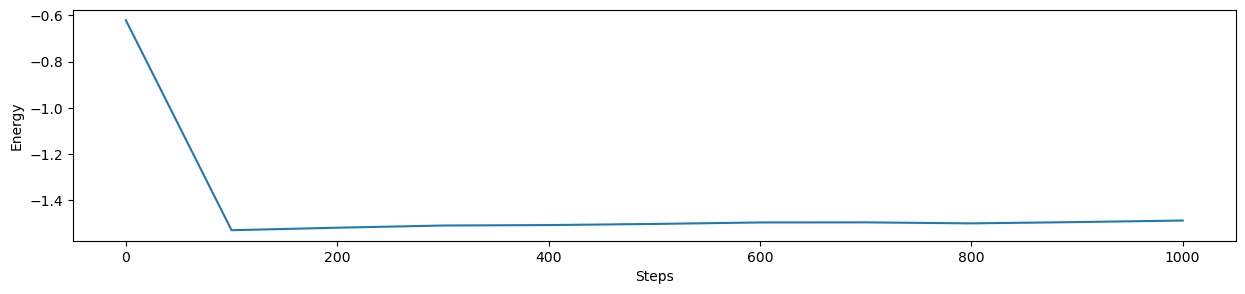

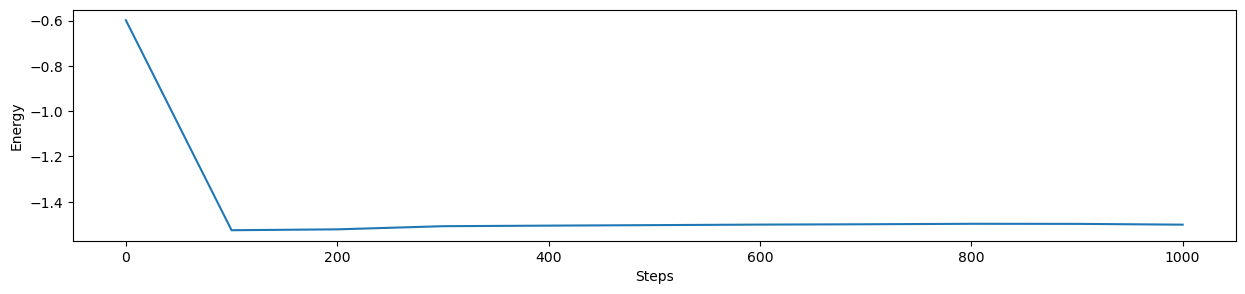

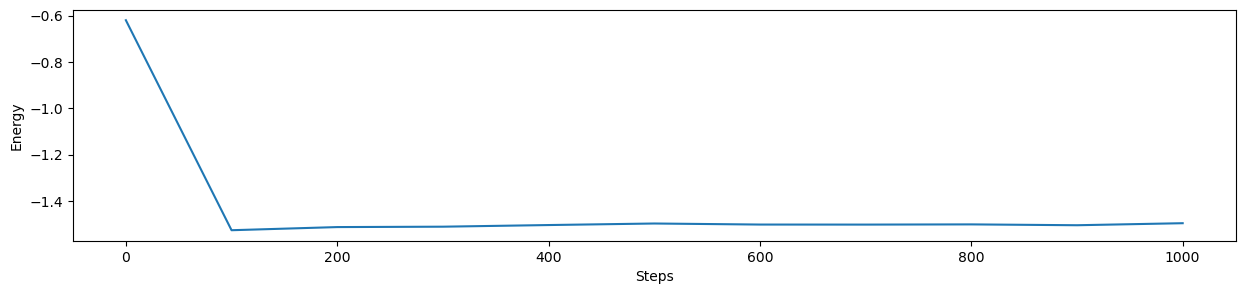

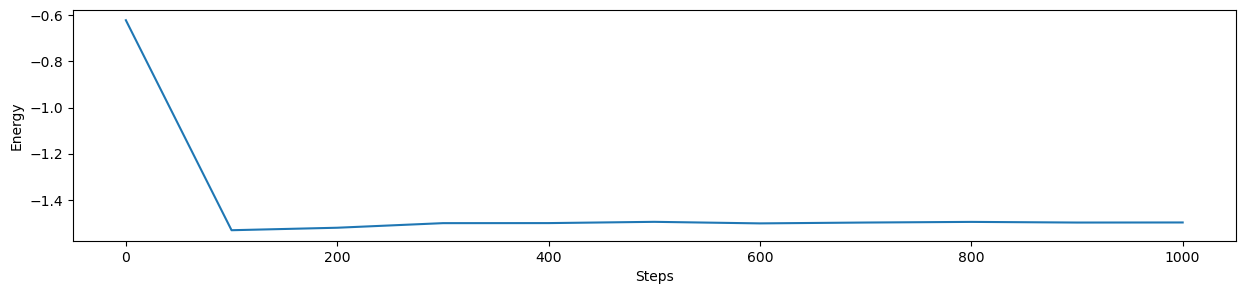

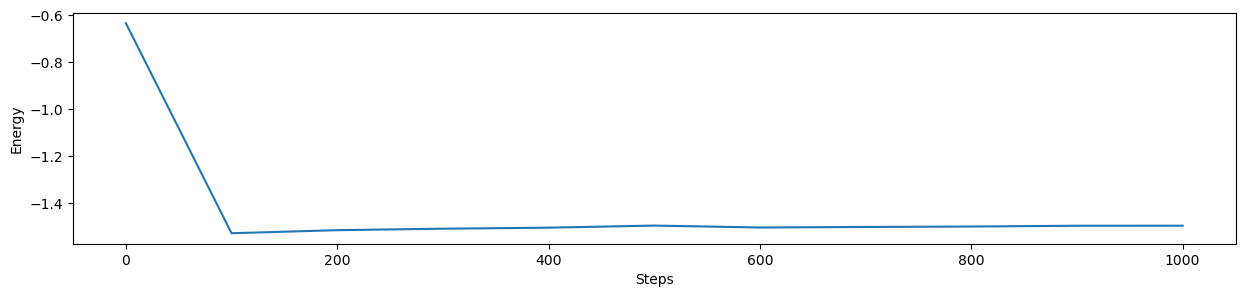

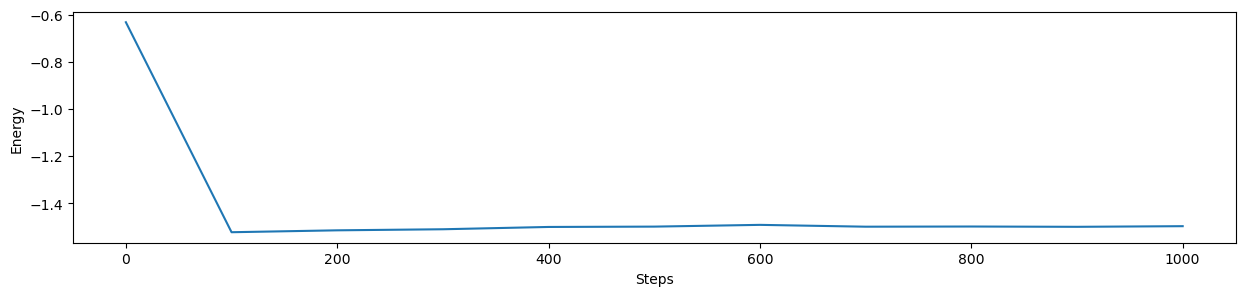

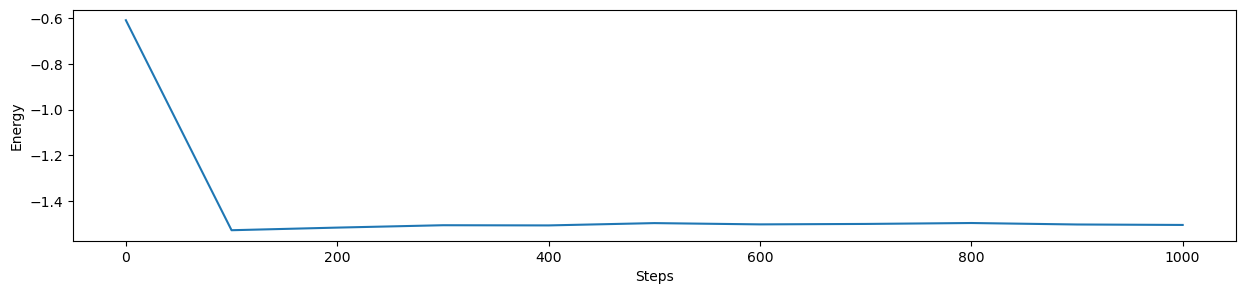

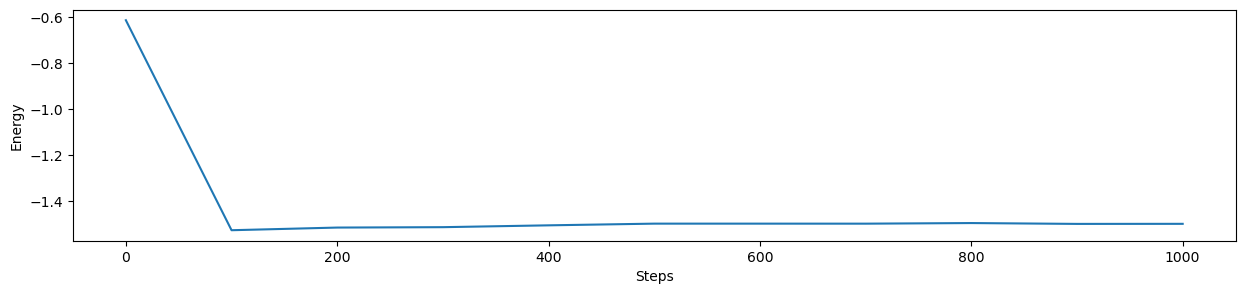

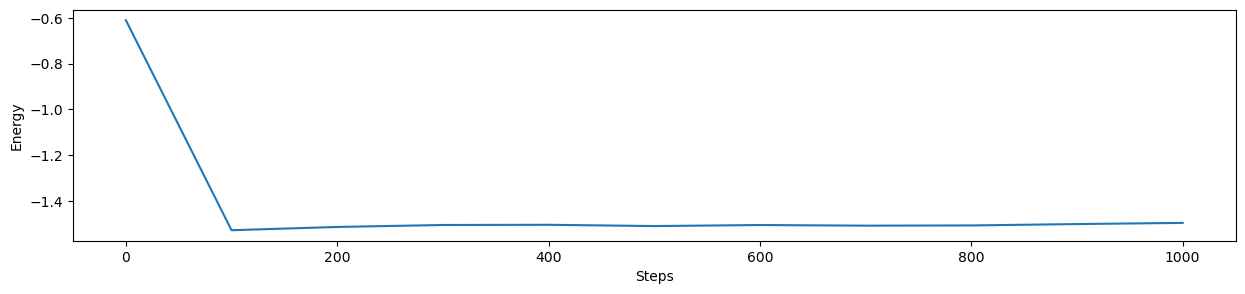

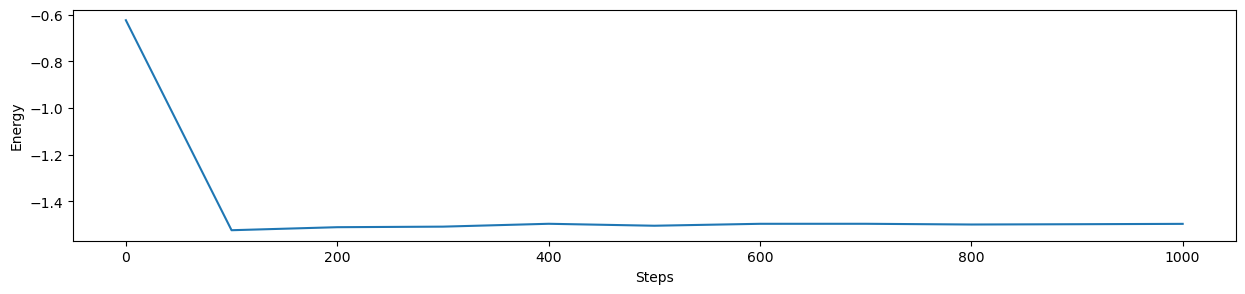

In [43]:
# Plot energy for all relaxation simulations
for sim in sim_list_rel:
    sim.analysis.plot_energy()

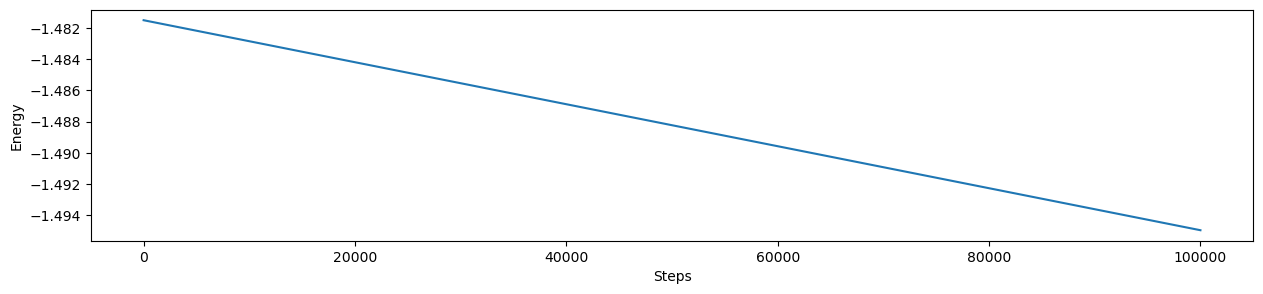

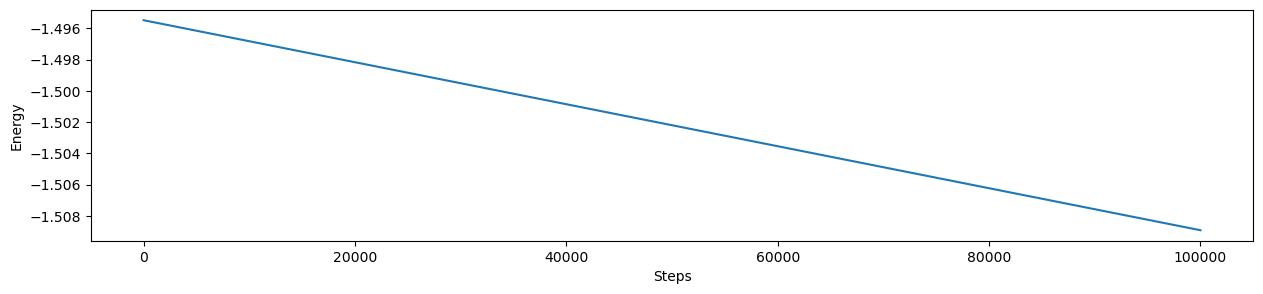

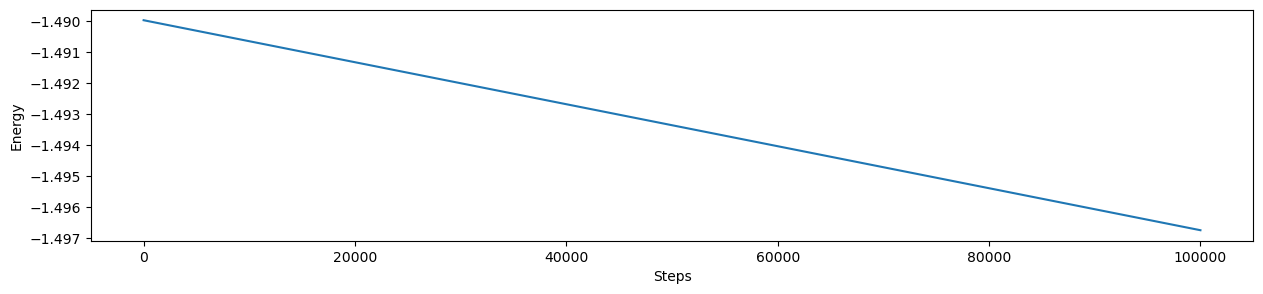

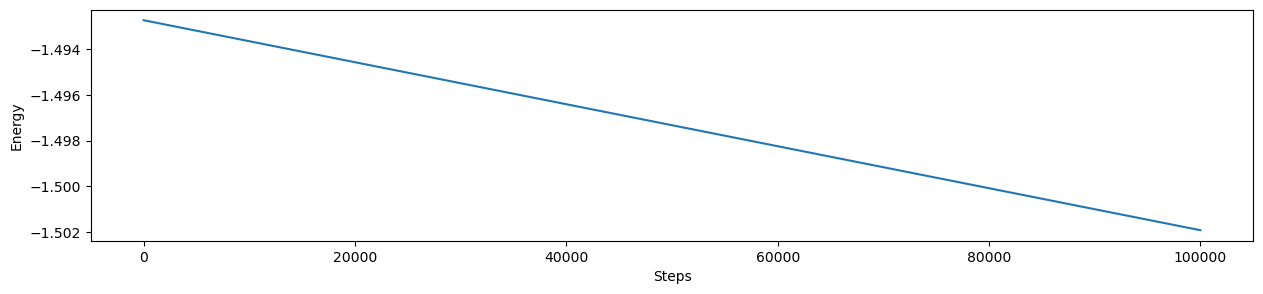

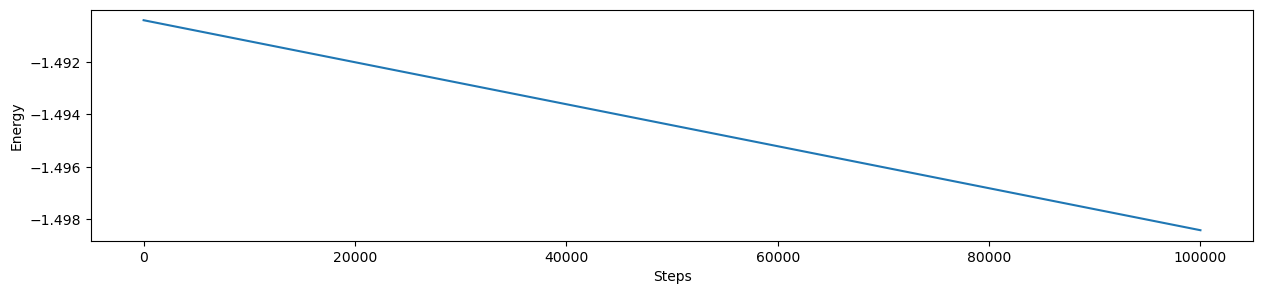

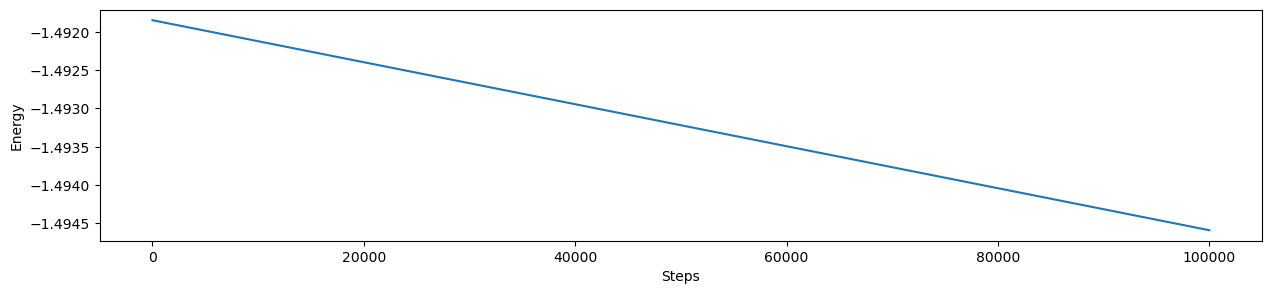

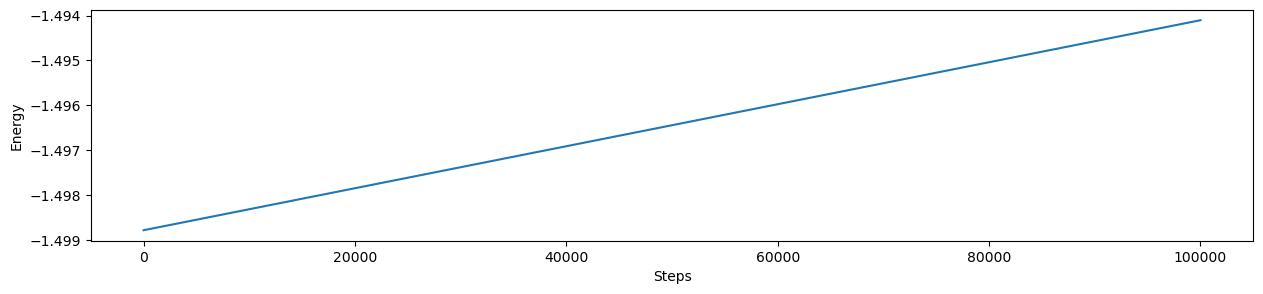

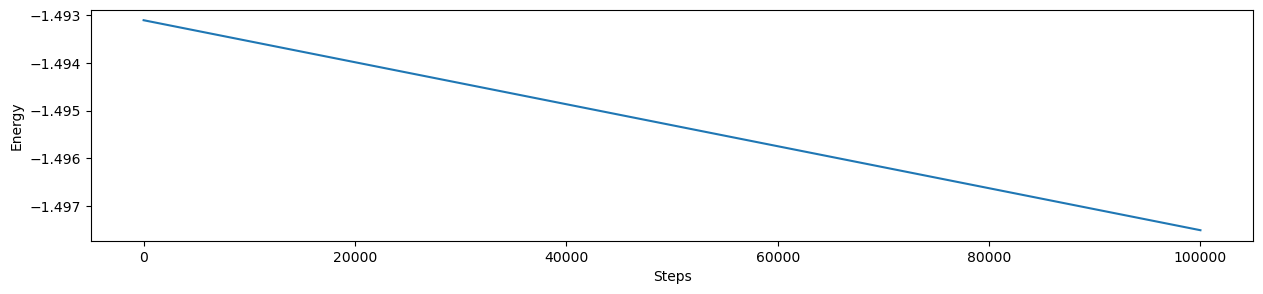

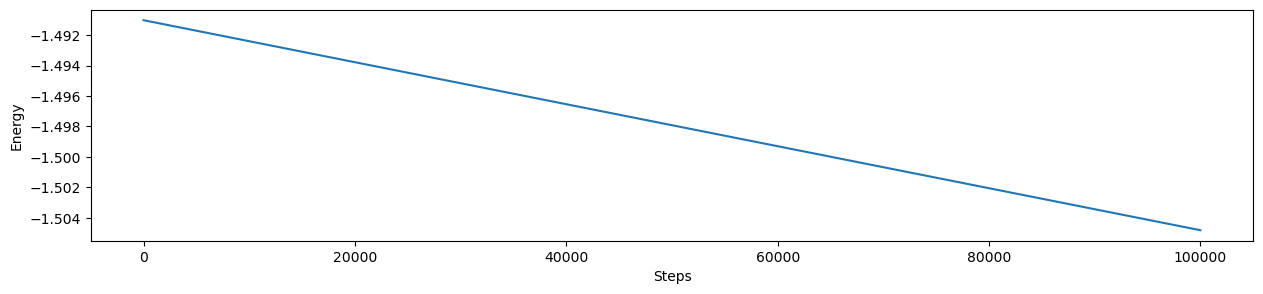

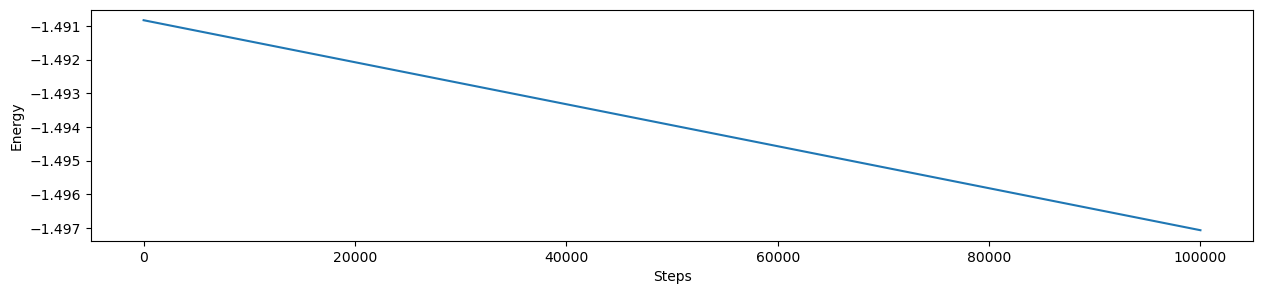

In [44]:
# Plot energy for all equilibration simulations
for sim in sim_list_eq:
    sim.analysis.plot_energy()

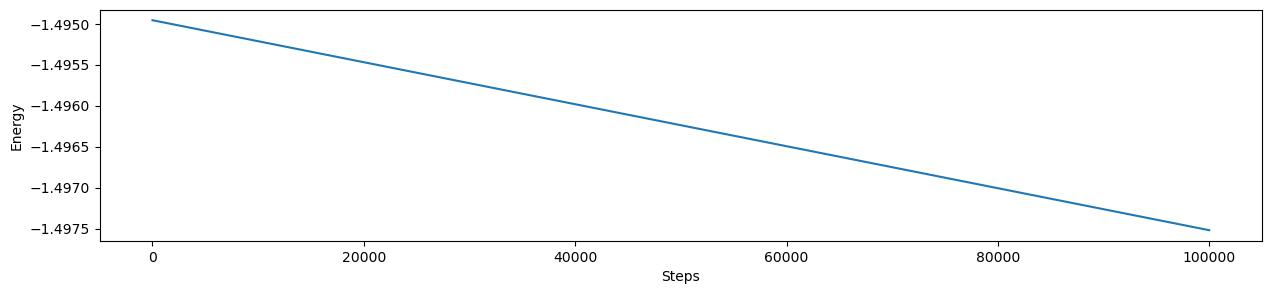

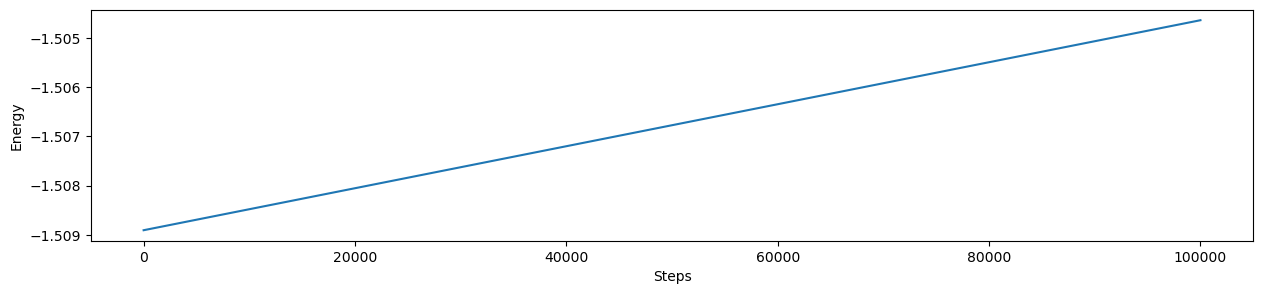

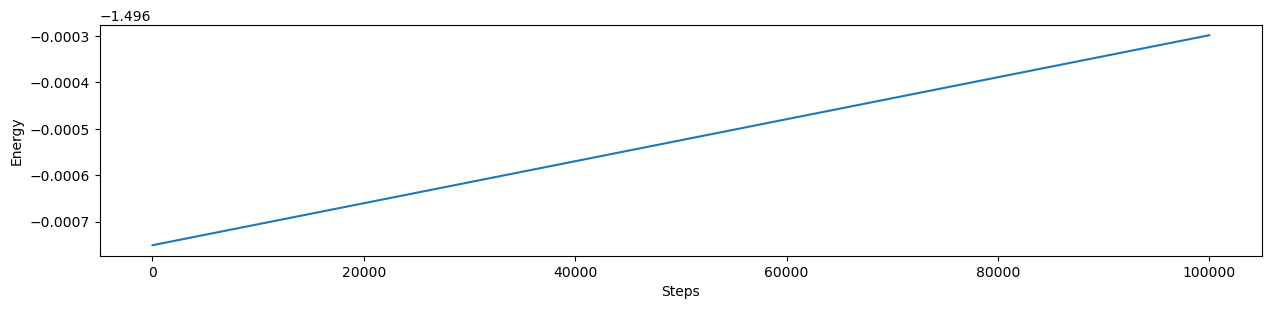

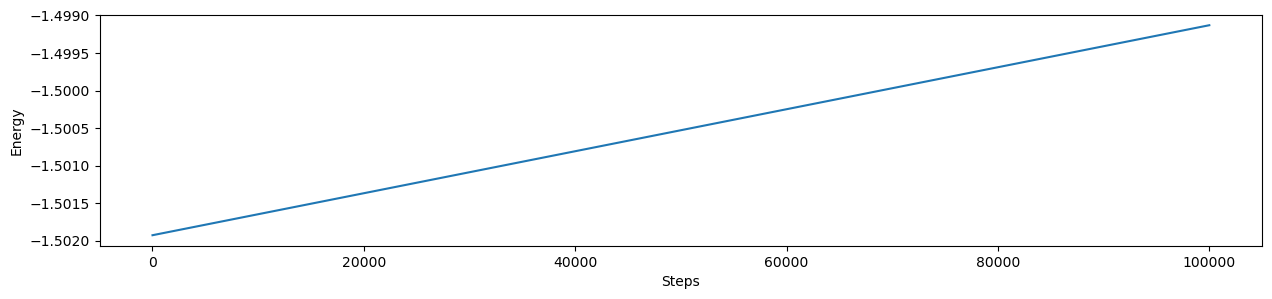

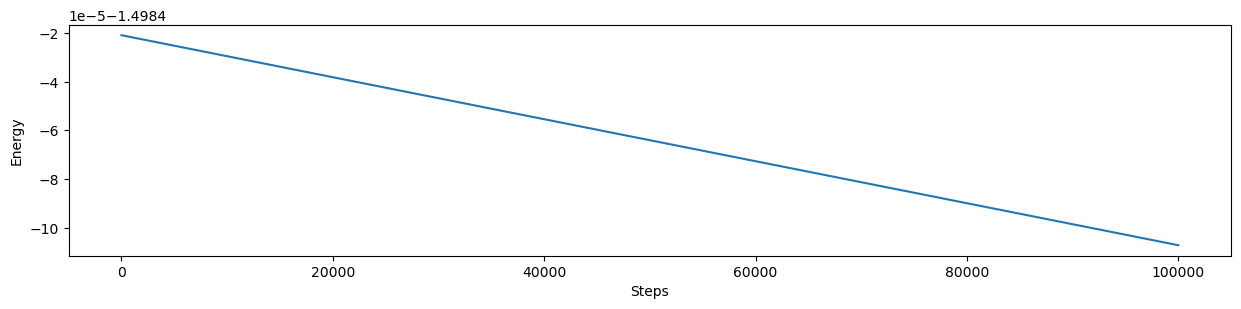

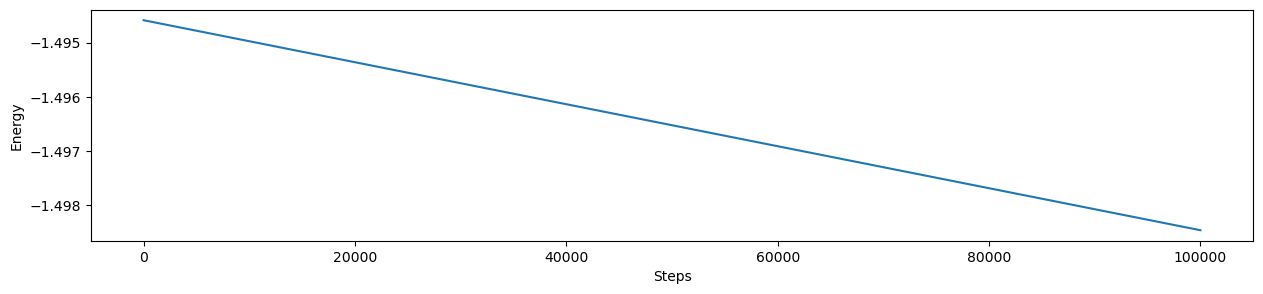

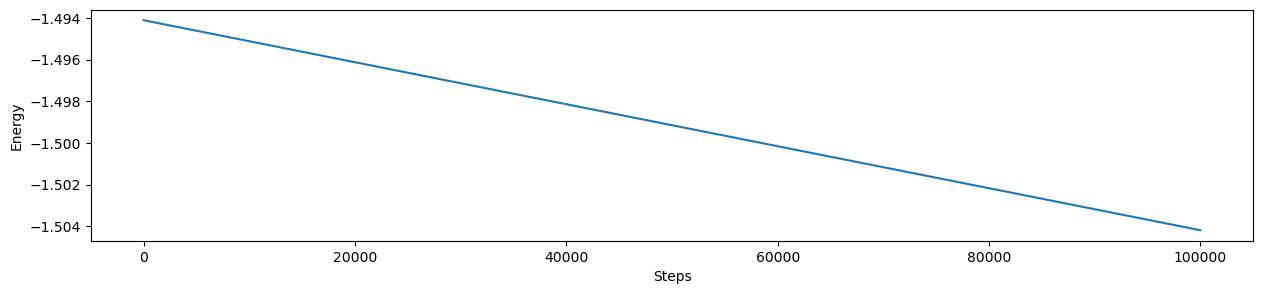

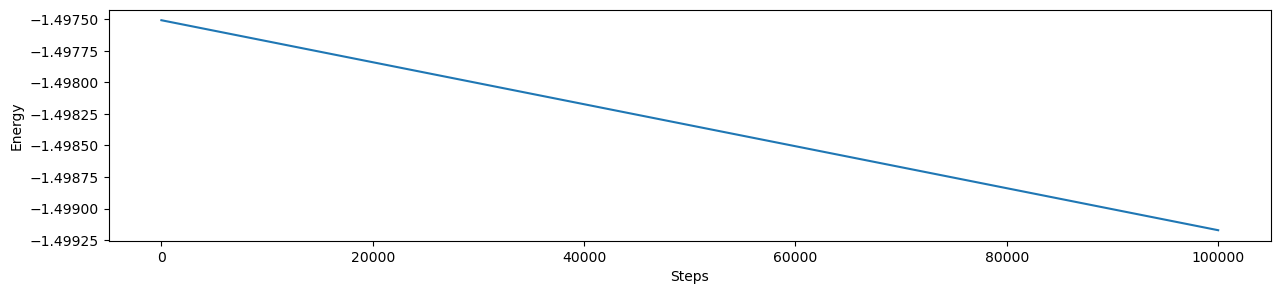

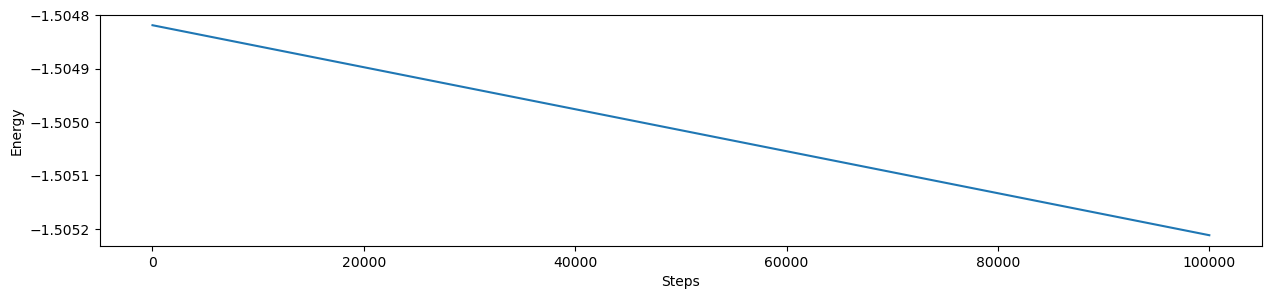

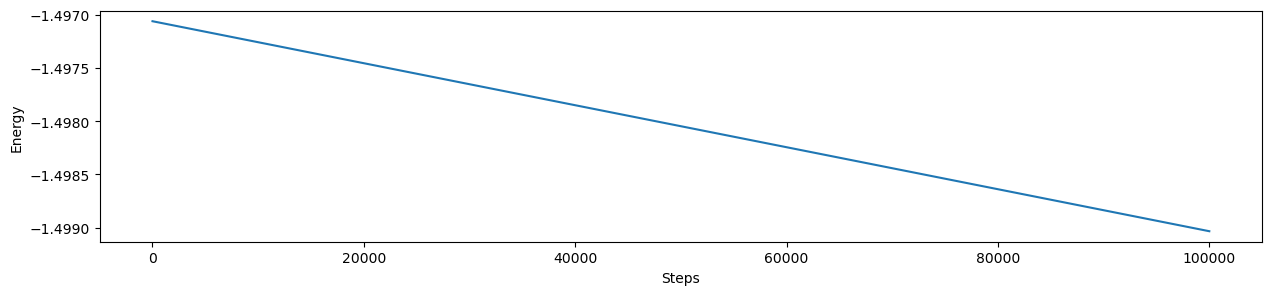

In [45]:
# Plot energy for all prod simulations
for sim in sim_list_prod:
    sim.analysis.plot_energy()